# Optuna Tuning | RandomForestClassifier
**RandomForestClassifier** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

### 0.2 Constants

In [3]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'rf' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

SCORING = 'f1_macro'
N_TRIALS = 100
RANDOM_STATE = 38

### 0.3 Loading datasets

In [4]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [5]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [6]:
NUMERICAL_COLUMNS = [
    'time_in_hospital', 'age', 'num_lab_procedures',
    'num_diagnoses', 'num_inpatient'
]

In [7]:
scaler = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [8]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 37607, 1: 4441})
Test set: Counter({0: 16117, 1: 1904})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [55]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = RandomForestClassifier(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    f1_score = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [56]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-29 14:25:02,022] Using an existing study with name 'Diabetes_130-US' instead of creating a new one.


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [170]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-28 21:51:00,388] Trial 0 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-28 21:51:00,461] Trial 8 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 34}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-28 21:51:00,481] Trial 7 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:02,366] Trial 2 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 50}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:03,298] Trial 3 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:03,524] Trial 9 finished with value: 0.47212353264706886 and parameters: {'max_depth': 12, 'min_samples_leaf': 58}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:03,999] Trial 10 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 50}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-28 21:51:04,014] Trial 4 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 48}. Best is trial 0 with value: 0.47212353264706886.
[I 2024-12-28 21:51:04,027] Trial 6 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 46}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:04,295] Trial 11 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 42}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:05,264] Trial 5 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.47212353264706886.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:06,387] Trial 1 finished with value: 0.47235443243141956 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47235443243141956


[I 2024-12-28 21:51:08,178] Trial 14 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:08,970] Trial 12 finished with value: 0.47212353264706886 and parameters: {'max_depth': 6, 'min_samples_leaf': 44}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:12,009] Trial 13 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:12,845] Trial 16 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 58}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:13,336] Trial 15 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 48}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:14,179] Trial 17 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:14,790] Trial 18 finished with value: 0.47212353264706886 and parameters: {'max_depth': 30, 'min_samples_leaf': 54}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:15,451] Trial 21 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 38}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:16,155] Trial 22 finished with value: 0.47212353264706886 and parameters: {'max_depth': 12, 'min_samples_leaf': 36}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:16,943] Trial 19 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:17,449] Trial 20 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:19,608] Trial 24 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.47235443243141956.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:20,349] Trial 23 finished with value: 0.47258533151549786 and parameters: {'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 23 with value: 0.47258533151549786.
[I 2024-12-28 21:51:20,509] Trial 25 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 24}. Best is trial 23 with value: 0.47258533151549786.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:22,480] Trial 28 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 40}. Best is trial 23 with value: 0.47258533151549786.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:25,055] Trial 33 finished with value: 0.47212353264706886 and parameters: {'max_depth': 6, 'min_samples_leaf': 52}. Best is trial 23 with value: 0.47258533151549786.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:25,334] Trial 27 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 12}. Best is trial 23 with value: 0.47258533151549786.
[I 2024-12-28 21:51:25,407] Trial 32 finished with value: 0.47212353264706886 and parameters: {'max_depth': 8, 'min_samples_leaf': 32}. Best is trial 23 with value: 0.47258533151549786.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:25,737] Trial 29 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 18}. Best is trial 23 with value: 0.47258533151549786.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:26,866] Trial 31 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 26}. Best is trial 23 with value: 0.47258533151549786.
[I 2024-12-28 21:51:26,997] Trial 26 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 26 with value: 0.473173424416047.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:51:27,523] Trial 34 finished with value: 0.47212353264706886 and parameters: {'max_depth': 10, 'min_samples_leaf': 28}. Best is trial 26 with value: 0.473173424416047.
[I 2024-12-28 21:51:27,719] Trial 30 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 26 with value: 0.473173424416047.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:31,113] Trial 35 finished with value: 0.47212353264706886 and parameters: {'max_depth': 14, 'min_samples_leaf': 16}. Best is trial 26 with value: 0.473173424416047.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:33,381] Trial 42 finished with value: 0.47212353264706886 and parameters: {'max_depth': 6, 'min_samples_leaf': 44}. Best is trial 26 with value: 0.473173424416047.
[I 2024-12-28 21:51:33,427] Trial 43 finished with value: 0.47212353264706886 and parameters: {'max_depth': 4, 'min_samples_leaf': 60}. Best is trial 26 with value: 0.473173424416047.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:33,806] Trial 37 finished with value: 0.47235443173114716 and parameters: {'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 26 with value: 0.473173424416047.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47235443173114716


[I 2024-12-28 21:51:35,015] Trial 36 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average F1-score: 0.4732872294982357


[I 2024-12-28 21:51:36,360] Trial 38 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:36,539] Trial 40 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 22}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:37,228] Trial 41 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 14}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:37,323] Trial 39 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:40,453] Trial 45 finished with value: 0.4725781979737643 and parameters: {'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47321726 0.47212806 0.47212806]
Average F1-score: 0.4725781979737643


[I 2024-12-28 21:51:41,753] Trial 44 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:51:42,235] Trial 46 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average F1-score: 0.4732872294982357


[I 2024-12-28 21:51:43,023] Trial 47 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:44,931] Trial 49 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 16}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:45,996] Trial 48 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:46,857] Trial 50 finished with value: 0.47235443173114716 and parameters: {'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:46,933] Trial 51 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 12}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47235443173114716
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:50,097] Trial 52 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179


[I 2024-12-28 21:51:50,599] Trial 54 finished with value: 0.4725781986740367 and parameters: {'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47321726 0.47328256 0.47212806]
Average F1-score: 0.4725781986740367


[I 2024-12-28 21:51:50,939] Trial 55 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179


[I 2024-12-28 21:51:51,341] Trial 53 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:51:52,969] Trial 56 finished with value: 0.47212353264706886 and parameters: {'max_depth': 28, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:56,745] Trial 57 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:56,819] Trial 60 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 12}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:56,854] Trial 58 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average F1-score: 0.4732872294982357


[I 2024-12-28 21:51:57,865] Trial 59 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:51:58,030] Trial 61 finished with value: 0.47212353264706886 and parameters: {'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:51:59,876] Trial 62 finished with value: 0.4725781979737643 and parameters: {'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47321726 0.47212806 0.47212806]
Average F1-score: 0.4725781979737643


[I 2024-12-28 21:52:01,504] Trial 63 finished with value: 0.47261655297780314 and parameters: {'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47368951 0.47270109 0.47266667 0.47259423 0.47143127]
Average F1-score: 0.47261655297780314


[I 2024-12-28 21:52:02,728] Trial 66 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:03,575] Trial 65 finished with value: 0.4725781986740367 and parameters: {'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:03,599] Trial 64 finished with value: 0.4725583163842101 and parameters: {'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47321726 0.47328256 0.47212806]
Average F1-score: 0.4725781986740367
Cross validation F1-scores: [0.47325166 0.47209842 0.47209842 0.47324816 0.47209492]
Average F1-score: 0.4725583163842101


[I 2024-12-28 21:52:05,256] Trial 68 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:05,897] Trial 67 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:52:08,584] Trial 71 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 12}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:10,782] Trial 73 finished with value: 0.47235443173114716 and parameters: {'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47235443173114716


[I 2024-12-28 21:52:11,389] Trial 69 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:11,528] Trial 70 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047
Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:52:12,608] Trial 72 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:52:14,200] Trial 75 finished with value: 0.47235443243141956 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47235443243141956


[I 2024-12-28 21:52:14,462] Trial 74 finished with value: 0.47327790302728784 and parameters: {'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47397459 0.47287318 0.47287318 0.47397104 0.47269752]
Average F1-score: 0.47327790302728784


[I 2024-12-28 21:52:15,030] Trial 76 finished with value: 0.47212353264706886 and parameters: {'max_depth': 24, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:17,006] Trial 77 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:17,206] Trial 79 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:18,183] Trial 78 finished with value: 0.4721926752101145 and parameters: {'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47266667 0.47273551 0.47136841 0.47262866 0.47156413]
Average F1-score: 0.4721926752101145


[I 2024-12-28 21:52:18,541] Trial 80 finished with value: 0.47258533151549786 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:22,022] Trial 81 finished with value: 0.47258533151549786 and parameters: {'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:24,874] Trial 85 finished with value: 0.47212353264706886 and parameters: {'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:25,069] Trial 84 finished with value: 0.47258533151549786 and parameters: {'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:25,436] Trial 82 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:52:25,993] Trial 83 finished with value: 0.4721926752101145 and parameters: {'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47266667 0.47273551 0.47136841 0.47262866 0.47156413]
Average F1-score: 0.4721926752101145


[I 2024-12-28 21:52:26,989] Trial 88 finished with value: 0.47212353264706886 and parameters: {'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:27,986] Trial 87 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179


[I 2024-12-28 21:52:28,615] Trial 86 finished with value: 0.4732872294982357 and parameters: {'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:28,660] Trial 90 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 14}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47290759 0.47304523 0.47301083 0.47314494 0.47432755]
Average F1-score: 0.4732872294982357
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:29,495] Trial 89 finished with value: 0.47258533151549786 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:30,454] Trial 91 finished with value: 0.47258533151549786 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:32,038] Trial 92 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


[I 2024-12-28 21:52:34,258] Trial 93 finished with value: 0.4721926752101145 and parameters: {'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47266667 0.47273551 0.47136841 0.47262866 0.47156413]
Average F1-score: 0.4721926752101145


[I 2024-12-28 21:52:34,947] Trial 99 finished with value: 0.47212353264706886 and parameters: {'max_depth': 18, 'min_samples_leaf': 34}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886


[I 2024-12-28 21:52:35,276] Trial 95 finished with value: 0.47212353264706886 and parameters: {'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.4732872294982357.
[I 2024-12-28 21:52:35,331] Trial 96 finished with value: 0.47235443243141956 and parameters: {'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47212806 0.47212806]
Average F1-score: 0.47212353264706886
Cross validation F1-scores: [0.47213156 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47235443243141956


[I 2024-12-28 21:52:35,508] Trial 94 finished with value: 0.47258533151549786 and parameters: {'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47213156 0.47209842 0.47328256 0.47212806]
Average F1-score: 0.47258533151549786


[I 2024-12-28 21:52:35,897] Trial 97 finished with value: 0.472572076771179 and parameters: {'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47328605 0.47209842 0.47209842 0.47328256 0.47209492]
Average F1-score: 0.472572076771179


[I 2024-12-28 21:52:37,373] Trial 98 finished with value: 0.473173424416047 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.4732872294982357.


Cross validation F1-scores: [0.47276993 0.47390332 0.47263224 0.47269752 0.47386412]
Average F1-score: 0.473173424416047


In [171]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 36
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2}
Best Value: 0.4732872294982357


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [57]:
optuna.visualization.plot_optimization_history(study)

In [58]:
optuna.visualization.plot_slice(study)

In [59]:
optuna.visualization.plot_param_importances(study)

In [60]:
optuna.visualization.plot_parallel_coordinate(study)

In [61]:
optuna.visualization.plot_contour(study)

In [62]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [63]:
# Fit best model on the training set
best_params = study.best_params

model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, random_state=38)

In [64]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [65]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.9018740487062404
Test accuracy:  0.8935686143943178


In [66]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.89      1.00      0.94     16117
      Early-readmission       0.06      0.00      0.00      1904

               accuracy                           0.89     18021
              macro avg       0.48      0.50      0.47     18021
           weighted avg       0.81      0.89      0.84     18021



In [67]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

<Axes: >

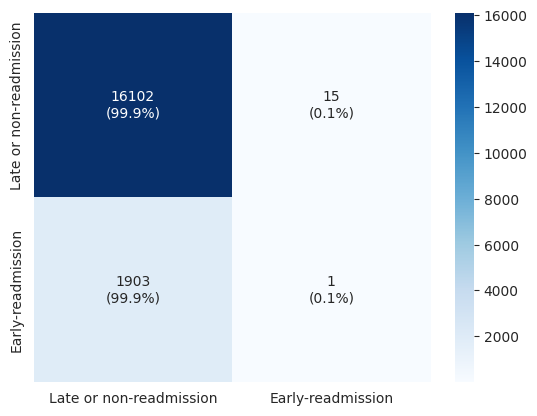

In [68]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [41]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 4, 30, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 60, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [42]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-29 14:24:50,181] Using an existing study with name 'Diabetes_130-US' instead of creating a new one.


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [186]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-28 21:52:47,889] Trial 6 finished with value: 0.4847983425783208 and parameters: {'max_depth': 4, 'min_samples_leaf': 26}. Best is trial 6 with value: 0.4847983425783208.
[I 2024-12-28 21:52:48,017] Trial 9 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.47704766 0.47591803 0.48781896 0.48449493 0.49871213]
Average F1-score: 0.4847983425783208
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202


[I 2024-12-28 21:52:48,232] Trial 10 finished with value: 0.48041554766073097 and parameters: {'max_depth': 6, 'min_samples_leaf': 20}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:48,335] Trial 7 finished with value: 0.47609601262958207 and parameters: {'max_depth': 6, 'min_samples_leaf': 60}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.4788587  0.48123752 0.47893053 0.47409882 0.48895217]
Average F1-score: 0.48041554766073097
Cross validation F1-scores: [0.47580253 0.47370454 0.47569498 0.47328385 0.48199416]
Average F1-score: 0.47609601262958207


[I 2024-12-28 21:52:48,493] Trial 3 finished with value: 0.47228557271788596 and parameters: {'max_depth': 18, 'min_samples_leaf': 48}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:48,496] Trial 2 finished with value: 0.47176678555115503 and parameters: {'max_depth': 28, 'min_samples_leaf': 44}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:48,577] Trial 5 finished with value: 0.4714257042614001 and parameters: {'max_depth': 10, 'min_samples_leaf': 38}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:48,631] Trial 4 finished with value: 0.4711661385981654 and parameters: {'max_depth': 10, 'min_samples_leaf': 28}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.46901266 0.47202701 0.4720121  0.46882987 0.47954622]
Average F1-score: 0.47228557271788596
Cross validation F1-scores: [0.47435984 0.46872326 0.46966377 0.46630448 0.47978259]
Average F1-score: 0.47176678555115503
Cross validation F1-scores: [0.47283818 0.46813529 0.47054035 0.46529472 0.48031999]
Average F1-score: 0.4714257042614001
Cross validation F1-scores: [0.47030021 0.46923521 0.46868634 0.46979199 0.47781695]
Average F1-score: 0.4711661385981654
Cross validation F1-scores: [0.47122185 0.46686028 0.47134054 0.46919558 0.47890217]
Average F1-score: 0.4715040826996745


[I 2024-12-28 21:52:48,675] Trial 11 finished with value: 0.4715040826996745 and parameters: {'max_depth': 20, 'min_samples_leaf': 46}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:48,821] Trial 8 finished with value: 0.4739607766823508 and parameters: {'max_depth': 18, 'min_samples_leaf': 26}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.47234163 0.47451175 0.47288345 0.47050561 0.47956144]
Average F1-score: 0.4739607766823508


[I 2024-12-28 21:52:49,216] Trial 1 finished with value: 0.470041334775118 and parameters: {'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 9 with value: 0.4855861982449202.
[I 2024-12-28 21:52:49,404] Trial 0 finished with value: 0.46670826038752666 and parameters: {'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.46799906 0.46967146 0.46711968 0.46987071 0.47554577]
Average F1-score: 0.470041334775118
Cross validation F1-scores: [0.46300411 0.46984126 0.46181174 0.46746414 0.47142005]
Average F1-score: 0.46670826038752666


[I 2024-12-28 21:52:55,556] Trial 12 finished with value: 0.48539120037443084 and parameters: {'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 9 with value: 0.4855861982449202.


Cross validation F1-scores: [0.47536809 0.4773856  0.49095311 0.48687438 0.49637483]
Average F1-score: 0.48539120037443084


[I 2024-12-28 21:52:56,188] Trial 17 finished with value: 0.48664376312535323 and parameters: {'max_depth': 4, 'min_samples_leaf': 50}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:56,273] Trial 13 finished with value: 0.4734343086367301 and parameters: {'max_depth': 20, 'min_samples_leaf': 56}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47421225 0.47778435 0.4899269  0.48352127 0.50777405]
Average F1-score: 0.48664376312535323
Cross validation F1-scores: [0.47437593 0.46993567 0.47468615 0.46833624 0.47983754]
Average F1-score: 0.4734343086367301


[I 2024-12-28 21:52:56,648] Trial 15 finished with value: 0.4727475713628391 and parameters: {'max_depth': 20, 'min_samples_leaf': 40}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:56,700] Trial 18 finished with value: 0.4778343751528665 and parameters: {'max_depth': 6, 'min_samples_leaf': 46}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:56,701] Trial 14 finished with value: 0.4727475713628391 and parameters: {'max_depth': 28, 'min_samples_leaf': 40}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:56,784] Trial 16 finished with value: 0.4729892505584412 and parameters: {'max_depth': 24, 'min_samples_leaf': 50}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47448345 0.47009249 0.47298384 0.4653436  0.48083448]
Average F1-score: 0.4727475713628391
Cross validation F1-scores: [0.4758436  0.47192849 0.4791292  0.47709604 0.48517454]
Average F1-score: 0.4778343751528665
Cross validation F1-scores: [0.47448345 0.47009249 0.47298384 0.4653436  0.48083448]
Average F1-score: 0.4727475713628391
Cross validation F1-scores: [0.47363908 0.47058848 0.47395498 0.46645971 0.480304  ]
Average F1-score: 0.4729892505584412


[I 2024-12-28 21:52:57,154] Trial 19 finished with value: 0.4705960866616109 and parameters: {'max_depth': 12, 'min_samples_leaf': 36}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:57,255] Trial 20 finished with value: 0.47358997284134735 and parameters: {'max_depth': 8, 'min_samples_leaf': 22}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4700389  0.46988189 0.47056315 0.46640345 0.47609304]
Average F1-score: 0.4705960866616109
Cross validation F1-scores: [0.47261039 0.47641777 0.47153732 0.47121233 0.47617206]
Average F1-score: 0.47358997284134735


[I 2024-12-28 21:52:57,825] Trial 21 finished with value: 0.4710061475457653 and parameters: {'max_depth': 14, 'min_samples_leaf': 14}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:52:57,995] Trial 23 finished with value: 0.47342075797509553 and parameters: {'max_depth': 8, 'min_samples_leaf': 32}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46950009 0.46907559 0.46952927 0.46830707 0.47861872]
Average F1-score: 0.4710061475457653
Cross validation F1-scores: [0.47279192 0.47528148 0.47197158 0.47011617 0.47694263]
Average F1-score: 0.47342075797509553


[I 2024-12-28 21:52:58,137] Trial 22 finished with value: 0.4707415993579632 and parameters: {'max_depth': 14, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47042679 0.46878441 0.46764477 0.46719887 0.47965316]
Average F1-score: 0.4707415993579632


[I 2024-12-28 21:53:03,778] Trial 25 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average F1-score: 0.4860508898459579


[I 2024-12-28 21:53:04,665] Trial 32 finished with value: 0.48539120037443084 and parameters: {'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:04,784] Trial 26 finished with value: 0.47225691031770295 and parameters: {'max_depth': 14, 'min_samples_leaf': 32}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47536809 0.4773856  0.49095311 0.48687438 0.49637483]
Average F1-score: 0.48539120037443084
Cross validation F1-scores: [0.47281762 0.4725406  0.46759568 0.46862457 0.47970608]
Average F1-score: 0.47225691031770295


[I 2024-12-28 21:53:05,060] Trial 27 finished with value: 0.47403274368955134 and parameters: {'max_depth': 8, 'min_samples_leaf': 12}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:05,069] Trial 31 finished with value: 0.4733007516163754 and parameters: {'max_depth': 10, 'min_samples_leaf': 60}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:05,221] Trial 33 finished with value: 0.48533936718856385 and parameters: {'max_depth': 4, 'min_samples_leaf': 6}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47369143 0.47393907 0.47313938 0.47195289 0.47744095]
Average F1-score: 0.47403274368955134
Cross validation F1-scores: [0.47572604 0.4683907  0.47562807 0.46829802 0.47846093]
Average F1-score: 0.4733007516163754
Cross validation F1-scores: [0.47703985 0.47797284 0.48858591 0.48650951 0.49658872]
Average F1-score: 0.48533936718856385


[I 2024-12-28 21:53:05,369] Trial 30 finished with value: 0.4715809335965909 and parameters: {'max_depth': 16, 'min_samples_leaf': 22}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.471272   0.47044024 0.46933129 0.4683504  0.47851075]
Average F1-score: 0.4715809335965909


[I 2024-12-28 21:53:05,699] Trial 28 finished with value: 0.46892445935736643 and parameters: {'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:05,781] Trial 29 finished with value: 0.46892445935736643 and parameters: {'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:05,870] Trial 34 finished with value: 0.4800104278255738 and parameters: {'max_depth': 6, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46746808 0.47093293 0.46472612 0.46847854 0.47301662]
Average F1-score: 0.46892445935736643
Cross validation F1-scores: [0.46746808 0.47093293 0.46472612 0.46847854 0.47301662]
Average F1-score: 0.46892445935736643
Cross validation F1-scores: [0.47853363 0.48035518 0.47721801 0.47509551 0.48884981]
Average F1-score: 0.4800104278255738


[I 2024-12-28 21:53:05,989] Trial 24 finished with value: 0.4578616303710904 and parameters: {'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.45122568 0.45792744 0.45692606 0.45812588 0.46510309]
Average F1-score: 0.4578616303710904


[I 2024-12-28 21:53:06,414] Trial 35 finished with value: 0.4742857945041017 and parameters: {'max_depth': 8, 'min_samples_leaf': 10}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47656186 0.47491024 0.47089343 0.47372075 0.47534269]
Average F1-score: 0.4742857945041017


[I 2024-12-28 21:53:12,560] Trial 36 finished with value: 0.4740827147119967 and parameters: {'max_depth': 30, 'min_samples_leaf': 52}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4754445  0.46923521 0.47467655 0.47081617 0.48024115]
Average F1-score: 0.4740827147119967


[I 2024-12-28 21:53:13,222] Trial 38 finished with value: 0.4851639186873721 and parameters: {'max_depth': 4, 'min_samples_leaf': 42}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47513425 0.47611694 0.48434387 0.48459917 0.50562536]
Average F1-score: 0.4851639186873721


[I 2024-12-28 21:53:13,675] Trial 40 finished with value: 0.4761453529744292 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:13,681] Trial 42 finished with value: 0.48550376342534723 and parameters: {'max_depth': 4, 'min_samples_leaf': 28}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:13,687] Trial 37 finished with value: 0.47325598557818765 and parameters: {'max_depth': 10, 'min_samples_leaf': 56}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:13,791] Trial 39 finished with value: 0.4761453529744292 and parameters: {'max_depth': 6, 'min_samples_leaf': 54}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47206996 0.47404187 0.47744566 0.47409052 0.48307875]Cross validation F1-scores: [0.47704766 0.47675524 0.4872864  0.48582597 0.50060355]
Average F1-score: 0.48550376342534723

Average F1-score: 0.4761453529744292
Cross validation F1-scores: [0.47591601 0.47099888 0.47351853 0.46823554 0.47761097]
Average F1-score: 0.47325598557818765
Cross validation F1-scores: [0.47206996 0.47404187 0.47744566 0.47409052 0.48307875]
Average F1-score: 0.4761453529744292


[I 2024-12-28 21:53:14,234] Trial 43 finished with value: 0.4848160939105761 and parameters: {'max_depth': 4, 'min_samples_leaf': 34}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:14,359] Trial 46 finished with value: 0.48457051464930856 and parameters: {'max_depth': 4, 'min_samples_leaf': 38}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:14,398] Trial 41 finished with value: 0.47228557271788596 and parameters: {'max_depth': 24, 'min_samples_leaf': 48}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47549107 0.47888066 0.48395274 0.48340925 0.50234675]
Average F1-score: 0.4848160939105761
Cross validation F1-scores: [0.47494731 0.47734562 0.48216804 0.48468099 0.50371062]
Average F1-score: 0.48457051464930856
Cross validation F1-scores: [0.46901266 0.47202701 0.4720121  0.46882987 0.47954622]
Average F1-score: 0.47228557271788596


[I 2024-12-28 21:53:15,038] Trial 45 finished with value: 0.47803307902019254 and parameters: {'max_depth': 6, 'min_samples_leaf': 28}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:15,206] Trial 44 finished with value: 0.4733814010148528 and parameters: {'max_depth': 8, 'min_samples_leaf': 44}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47689889 0.47753816 0.47523126 0.47664892 0.48384816]
Average F1-score: 0.47803307902019254
Cross validation F1-scores: [0.47493007 0.4684036  0.47481238 0.47031744 0.47844351]
Average F1-score: 0.4733814010148528


[I 2024-12-28 21:53:15,954] Trial 47 finished with value: 0.4716935260262402 and parameters: {'max_depth': 10, 'min_samples_leaf': 24}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47178396 0.46989137 0.46866143 0.46962352 0.47850735]
Average F1-score: 0.4716935260262402


[I 2024-12-28 21:53:20,593] Trial 48 finished with value: 0.48529569032382697 and parameters: {'max_depth': 4, 'min_samples_leaf': 58}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47382025 0.48058155 0.48627668 0.48352127 0.5022787 ]
Average F1-score: 0.48529569032382697


[I 2024-12-28 21:53:21,632] Trial 52 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:21,652] Trial 50 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:21,656] Trial 49 finished with value: 0.4714086766848274 and parameters: {'max_depth': 8, 'min_samples_leaf': 50}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:21,711] Trial 51 finished with value: 0.48550376342534723 and parameters: {'max_depth': 4, 'min_samples_leaf': 28}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202
Cross validation F1-scores: [0.47277595 0.46850643 0.46702099 0.46905069 0.47968932]
Average F1-score: 0.4714086766848274
Cross validation F1-scores: [0.47704766 0.47675524 0.4872864  0.48582597 0.50060355]
Average F1-score: 0.48550376342534723


[I 2024-12-28 21:53:22,261] Trial 53 finished with value: 0.47882584556621055 and parameters: {'max_depth': 6, 'min_samples_leaf': 14}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:22,446] Trial 55 finished with value: 0.4764687883341104 and parameters: {'max_depth': 6, 'min_samples_leaf': 36}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47483553 0.47803698 0.48008671 0.47611058 0.48505942]
Average F1-score: 0.47882584556621055
Cross validation F1-scores: [0.47293609 0.47514802 0.47919125 0.47454518 0.48052339]
Average F1-score: 0.4764687883341104


[I 2024-12-28 21:53:22,500] Trial 54 finished with value: 0.47775745406786774 and parameters: {'max_depth': 6, 'min_samples_leaf': 30}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47761647 0.47799661 0.4744792  0.47547381 0.48322118]
Average F1-score: 0.47775745406786774


[I 2024-12-28 21:53:23,238] Trial 56 finished with value: 0.4716935260262402 and parameters: {'max_depth': 10, 'min_samples_leaf': 24}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47178396 0.46989137 0.46866143 0.46962352 0.47850735]
Average F1-score: 0.4716935260262402


[I 2024-12-28 21:53:23,492] Trial 57 finished with value: 0.4733814010148528 and parameters: {'max_depth': 8, 'min_samples_leaf': 44}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47493007 0.4684036  0.47481238 0.47031744 0.47844351]
Average F1-score: 0.4733814010148528


[I 2024-12-28 21:53:24,021] Trial 59 finished with value: 0.4771830412636426 and parameters: {'max_depth': 6, 'min_samples_leaf': 48}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47580253 0.47359165 0.47609691 0.4740216  0.48640251]
Average F1-score: 0.4771830412636426


[I 2024-12-28 21:53:24,757] Trial 58 finished with value: 0.4686483273526056 and parameters: {'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46497227 0.47141382 0.45992483 0.47207664 0.47485408]
Average F1-score: 0.4686483273526056


[I 2024-12-28 21:53:29,128] Trial 60 finished with value: 0.4721322989049989 and parameters: {'max_depth': 8, 'min_samples_leaf': 40}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46956481 0.46776302 0.47403054 0.4706594  0.47864373]
Average F1-score: 0.4721322989049989


[I 2024-12-28 21:53:29,631] Trial 63 finished with value: 0.48483762397488733 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:29,647] Trial 62 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:29,689] Trial 61 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47577651 0.47602617 0.49082707 0.48412584 0.49743252]
Average F1-score: 0.48483762397488733
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202


[I 2024-12-28 21:53:30,101] Trial 64 finished with value: 0.47882584556621055 and parameters: {'max_depth': 6, 'min_samples_leaf': 14}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47483553 0.47803698 0.48008671 0.47611058 0.48505942]
Average F1-score: 0.47882584556621055


[I 2024-12-28 21:53:30,358] Trial 65 finished with value: 0.4846995112610957 and parameters: {'max_depth': 4, 'min_samples_leaf': 22}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47640847 0.47740408 0.48904633 0.4839714  0.49666728]
Average F1-score: 0.4846995112610957


[I 2024-12-28 21:53:30,864] Trial 66 finished with value: 0.4769412234116646 and parameters: {'max_depth': 6, 'min_samples_leaf': 26}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4747329  0.47521447 0.47458873 0.47694883 0.48322118]
Average F1-score: 0.4769412234116646


[I 2024-12-28 21:53:31,389] Trial 68 finished with value: 0.4847983425783208 and parameters: {'max_depth': 4, 'min_samples_leaf': 26}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47704766 0.47591803 0.48781896 0.48449493 0.49871213]
Average F1-score: 0.4847983425783208


[I 2024-12-28 21:53:32,027] Trial 67 finished with value: 0.47032796137438754 and parameters: {'max_depth': 18, 'min_samples_leaf': 12}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46912559 0.46942588 0.46639415 0.47067871 0.47601547]
Average F1-score: 0.47032796137438754


[I 2024-12-28 21:53:32,609] Trial 69 finished with value: 0.4698880560221883 and parameters: {'max_depth': 10, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47097446 0.46622996 0.4675859  0.46722239 0.47742757]
Average F1-score: 0.4698880560221883


[I 2024-12-28 21:53:32,909] Trial 70 finished with value: 0.4731511208691682 and parameters: {'max_depth': 8, 'min_samples_leaf': 20}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47451709 0.4712962  0.47080296 0.47218289 0.47695647]
Average F1-score: 0.4731511208691682


[I 2024-12-28 21:53:33,284] Trial 71 finished with value: 0.4786026030169784 and parameters: {'max_depth': 6, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4768307  0.47744566 0.47875422 0.47568609 0.48429634]
Average F1-score: 0.4786026030169784


[I 2024-12-28 21:53:37,449] Trial 72 finished with value: 0.48550376342534723 and parameters: {'max_depth': 4, 'min_samples_leaf': 28}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47704766 0.47675524 0.4872864  0.48582597 0.50060355]
Average F1-score: 0.48550376342534723


[I 2024-12-28 21:53:37,944] Trial 74 finished with value: 0.48483762397488733 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:38,005] Trial 73 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47577651 0.47602617 0.49082707 0.48412584 0.49743252]
Average F1-score: 0.48483762397488733
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202


[I 2024-12-28 21:53:38,384] Trial 76 finished with value: 0.4862940497360452 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:38,502] Trial 75 finished with value: 0.4800104278255738 and parameters: {'max_depth': 6, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47703174 0.47692802 0.49020532 0.48635489 0.50095027]
Average F1-score: 0.4862940497360452
Cross validation F1-scores: [0.47853363 0.48035518 0.47721801 0.47509551 0.48884981]
Average F1-score: 0.4800104278255738


[I 2024-12-28 21:53:39,549] Trial 79 finished with value: 0.48394571982031265 and parameters: {'max_depth': 4, 'min_samples_leaf': 24}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47618324 0.47723642 0.48741166 0.48387172 0.49502556]
Average F1-score: 0.48394571982031265


[I 2024-12-28 21:53:39,981] Trial 77 finished with value: 0.4693494345770026 and parameters: {'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:40,076] Trial 78 finished with value: 0.47216663316582935 and parameters: {'max_depth': 26, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46703595 0.4699694  0.46492102 0.46945738 0.47536342]
Average F1-score: 0.4693494345770026
Cross validation F1-scores: [0.47055149 0.46733239 0.46989364 0.46954077 0.48351488]
Average F1-score: 0.47216663316582935


[I 2024-12-28 21:53:40,522] Trial 80 finished with value: 0.4787527112478365 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47832138 0.47963429 0.47589576 0.47617058 0.48374154]
Average F1-score: 0.4787527112478365


[I 2024-12-28 21:53:40,874] Trial 82 finished with value: 0.48483762397488733 and parameters: {'max_depth': 4, 'min_samples_leaf': 20}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:41,027] Trial 81 finished with value: 0.47882584556621055 and parameters: {'max_depth': 6, 'min_samples_leaf': 14}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47577651 0.47602617 0.49082707 0.48412584 0.49743252]
Average F1-score: 0.48483762397488733
Cross validation F1-scores: [0.47483553 0.47803698 0.48008671 0.47611058 0.48505942]
Average F1-score: 0.47882584556621055


[I 2024-12-28 21:53:41,314] Trial 83 finished with value: 0.4861918069362554 and parameters: {'max_depth': 4, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47509353 0.47644401 0.4909235  0.48627088 0.50222711]
Average F1-score: 0.4861918069362554


[I 2024-12-28 21:53:45,676] Trial 84 finished with value: 0.486241487421918 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47735144 0.47756834 0.48926709 0.48526677 0.5017538 ]
Average F1-score: 0.486241487421918


[I 2024-12-28 21:53:46,252] Trial 86 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202


[I 2024-12-28 21:53:46,769] Trial 85 finished with value: 0.473177010753653 and parameters: {'max_depth': 8, 'min_samples_leaf': 30}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47546082 0.47081797 0.47248048 0.47138386 0.47574193]
Average F1-score: 0.473177010753653


[I 2024-12-28 21:53:47,139] Trial 87 finished with value: 0.47939262870337923 and parameters: {'max_depth': 6, 'min_samples_leaf': 12}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.476141   0.47831452 0.48000873 0.47649124 0.48600766]
Average F1-score: 0.47939262870337923


[I 2024-12-28 21:53:47,801] Trial 88 finished with value: 0.47246743107040584 and parameters: {'max_depth': 8, 'min_samples_leaf': 8}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.46878438 0.47421906 0.47275181 0.47110096 0.47548095]
Average F1-score: 0.47246743107040584


[I 2024-12-28 21:53:48,026] Trial 89 finished with value: 0.4862940497360452 and parameters: {'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47703174 0.47692802 0.49020532 0.48635489 0.50095027]
Average F1-score: 0.4862940497360452


[I 2024-12-28 21:53:48,522] Trial 90 finished with value: 0.4860508898459579 and parameters: {'max_depth': 4, 'min_samples_leaf': 52}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47405569 0.47820741 0.48828495 0.48342602 0.50628038]
Average F1-score: 0.4860508898459579


[I 2024-12-28 21:53:48,771] Trial 91 finished with value: 0.4786026030169784 and parameters: {'max_depth': 6, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:48,848] Trial 92 finished with value: 0.4855861982449202 and parameters: {'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.4768307  0.47744566 0.47875422 0.47568609 0.48429634]
Average F1-score: 0.4786026030169784
Cross validation F1-scores: [0.47453044 0.47700646 0.4916959  0.4849858  0.4997124 ]
Average F1-score: 0.4855861982449202


[I 2024-12-28 21:53:49,081] Trial 94 finished with value: 0.48529569032382697 and parameters: {'max_depth': 4, 'min_samples_leaf': 58}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:49,123] Trial 95 finished with value: 0.4861918069362554 and parameters: {'max_depth': 4, 'min_samples_leaf': 16}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:49,141] Trial 93 finished with value: 0.4787527112478365 and parameters: {'max_depth': 6, 'min_samples_leaf': 22}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47382025 0.48058155 0.48627668 0.48352127 0.5022787 ]
Average F1-score: 0.48529569032382697
Cross validation F1-scores: [0.47509353 0.47644401 0.4909235  0.48627088 0.50222711]
Average F1-score: 0.4861918069362554
Cross validation F1-scores: [0.47832138 0.47963429 0.47589576 0.47617058 0.48374154]
Average F1-score: 0.4787527112478365


[I 2024-12-28 21:53:50,177] Trial 97 finished with value: 0.48533936718856385 and parameters: {'max_depth': 4, 'min_samples_leaf': 6}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:50,190] Trial 96 finished with value: 0.47928702987994576 and parameters: {'max_depth': 6, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:50,256] Trial 99 finished with value: 0.486241487421918 and parameters: {'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 17 with value: 0.48664376312535323.
[I 2024-12-28 21:53:50,351] Trial 98 finished with value: 0.47882584556621055 and parameters: {'max_depth': 6, 'min_samples_leaf': 14}. Best is trial 17 with value: 0.48664376312535323.


Cross validation F1-scores: [0.47703985 0.47797284 0.48858591 0.48650951 0.49658872]
Average F1-score: 0.48533936718856385
Cross validation F1-scores: [0.47832357 0.47857492 0.47770407 0.47896331 0.48286926]
Average F1-score: 0.47928702987994576
Cross validation F1-scores: [0.47735144 0.47756834 0.48926709 0.48526677 0.5017538 ]
Average F1-score: 0.486241487421918
Cross validation F1-scores: [0.47483553 0.47803698 0.48008671 0.47611058 0.48505942]
Average F1-score: 0.47882584556621055


In [187]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 17
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 50}
Best Value: 0.48664376312535323


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [43]:
optuna.visualization.plot_optimization_history(study)

In [44]:
optuna.visualization.plot_slice(study)

In [45]:
optuna.visualization.plot_param_importances(study)

In [46]:
optuna.visualization.plot_parallel_coordinate(study)

In [47]:
optuna.visualization.plot_contour(study)

In [48]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [49]:
# Fit best model on the training set
best_params = study.best_params

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, min_samples_leaf=50,
                                        random_state=38))])

In [50]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [51]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.6238584474885844
Test accuracy:  0.6204983075301038


In [52]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.92      0.63      0.75     16117
      Early-readmission       0.15      0.56      0.24      1904

               accuracy                           0.62     18021
              macro avg       0.54      0.59      0.49     18021
           weighted avg       0.84      0.62      0.69     18021



In [53]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

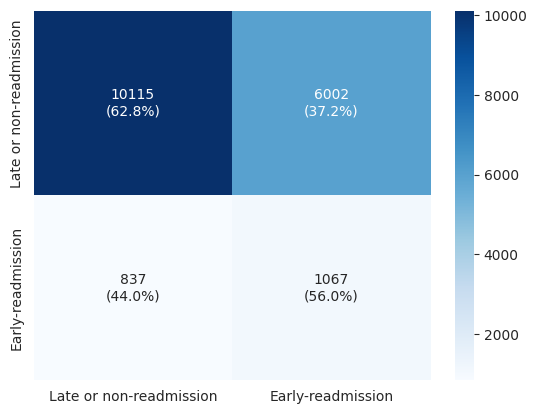

In [54]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [9]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 14, 40, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 16, 100, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [10]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-12-29 14:13:37,386] A new study created in Journal with name: Diabetes_130-US


### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [11]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-29 14:14:02,912] Trial 7 finished with value: 0.5397737874061885 and parameters: {'max_depth': 24, 'min_samples_leaf': 94}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53210624 0.53448142 0.54465914 0.53487734 0.55274479]
Average F1-score: 0.5397737874061885


[I 2024-12-29 14:14:03,158] Trial 5 finished with value: 0.5382861338715282 and parameters: {'max_depth': 28, 'min_samples_leaf': 96}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average F1-score: 0.5382861338715282


[I 2024-12-29 14:14:03,540] Trial 2 finished with value: 0.5379661429535958 and parameters: {'max_depth': 24, 'min_samples_leaf': 80}. Best is trial 7 with value: 0.5397737874061885.
[I 2024-12-29 14:14:03,557] Trial 9 finished with value: 0.5381252950581846 and parameters: {'max_depth': 26, 'min_samples_leaf': 80}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53099191 0.53613856 0.54259711 0.53382126 0.54628187]
Average F1-score: 0.5379661429535958
Cross validation F1-scores: [0.53243182 0.53570666 0.543788   0.53262727 0.54607272]
Average F1-score: 0.5381252950581846


[I 2024-12-29 14:14:04,088] Trial 6 finished with value: 0.5377638649493621 and parameters: {'max_depth': 36, 'min_samples_leaf': 64}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53192261 0.53194858 0.54257261 0.53666433 0.5457112 ]
Average F1-score: 0.5377638649493621


[I 2024-12-29 14:14:04,317] Trial 1 finished with value: 0.5360194381910508 and parameters: {'max_depth': 32, 'min_samples_leaf': 66}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53096403 0.52965227 0.54271515 0.53335026 0.54341548]
Average F1-score: 0.5360194381910508


[I 2024-12-29 14:14:04,621] Trial 4 finished with value: 0.5361806252814145 and parameters: {'max_depth': 34, 'min_samples_leaf': 56}. Best is trial 7 with value: 0.5397737874061885.
[I 2024-12-29 14:14:04,797] Trial 0 finished with value: 0.5358947979261375 and parameters: {'max_depth': 34, 'min_samples_leaf': 48}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.52995752 0.52860096 0.54329765 0.53337629 0.54567069]
Average F1-score: 0.5361806252814145
Cross validation F1-scores: [0.53002057 0.52840708 0.54471099 0.5351469  0.54118846]
Average F1-score: 0.5358947979261375


[I 2024-12-29 14:14:04,968] Trial 11 finished with value: 0.5374904207794714 and parameters: {'max_depth': 26, 'min_samples_leaf': 54}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53206508 0.53387894 0.54443224 0.53493754 0.54213831]
Average F1-score: 0.5374904207794714


[I 2024-12-29 14:14:05,170] Trial 3 finished with value: 0.5356906002544616 and parameters: {'max_depth': 28, 'min_samples_leaf': 48}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.5294294  0.52832705 0.54393308 0.53565789 0.54110559]
Average F1-score: 0.5356906002544616


[I 2024-12-29 14:14:07,130] Trial 10 finished with value: 0.5315868776744782 and parameters: {'max_depth': 24, 'min_samples_leaf': 22}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.5235079  0.52758164 0.54106146 0.5308882  0.5348952 ]
Average F1-score: 0.5315868776744782


[I 2024-12-29 14:14:08,132] Trial 8 finished with value: 0.5254726929311305 and parameters: {'max_depth': 30, 'min_samples_leaf': 16}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.51866031 0.52260245 0.53298216 0.52488934 0.5282292 ]
Average F1-score: 0.5254726929311305


[I 2024-12-29 14:14:28,230] Trial 12 finished with value: 0.538958345032287 and parameters: {'max_depth': 28, 'min_samples_leaf': 84}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53271957 0.53615667 0.54480907 0.53463901 0.54646741]
Average F1-score: 0.538958345032287


[I 2024-12-29 14:14:29,178] Trial 18 finished with value: 0.5394802445922181 and parameters: {'max_depth': 24, 'min_samples_leaf': 100}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53438826 0.53411361 0.54496121 0.53605603 0.54788211]
Average F1-score: 0.5394802445922181
Cross validation F1-scores: [0.52831002 0.53117812 0.54312633 0.53820503 0.54626618]
Average F1-score: 0.5374171362106047


[I 2024-12-29 14:14:29,380] Trial 15 finished with value: 0.5374171362106047 and parameters: {'max_depth': 36, 'min_samples_leaf': 62}. Best is trial 7 with value: 0.5397737874061885.
[I 2024-12-29 14:14:29,653] Trial 21 finished with value: 0.5379072078776932 and parameters: {'max_depth': 16, 'min_samples_leaf': 92}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.5370863  0.52743581 0.54094839 0.53468239 0.54938316]
Average F1-score: 0.5379072078776932


[I 2024-12-29 14:14:29,865] Trial 14 finished with value: 0.537119054725893 and parameters: {'max_depth': 28, 'min_samples_leaf': 62}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.52776723 0.52997346 0.54338338 0.53820503 0.54626618]
Average F1-score: 0.537119054725893


[I 2024-12-29 14:14:30,108] Trial 17 finished with value: 0.538059021196388 and parameters: {'max_depth': 36, 'min_samples_leaf': 70}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.5324912  0.53557918 0.54265765 0.53877737 0.54078971]
Average F1-score: 0.538059021196388


[I 2024-12-29 14:14:30,950] Trial 13 finished with value: 0.5358473053016873 and parameters: {'max_depth': 28, 'min_samples_leaf': 40}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.52754201 0.53032362 0.54737663 0.53493367 0.53906059]
Average F1-score: 0.5358473053016873


[I 2024-12-29 14:14:31,425] Trial 22 finished with value: 0.5370332301016021 and parameters: {'max_depth': 18, 'min_samples_leaf': 100}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53165086 0.52796166 0.54438688 0.53747507 0.54369167]
Average F1-score: 0.5370332301016021


[I 2024-12-29 14:14:31,723] Trial 19 finished with value: 0.5362452407828657 and parameters: {'max_depth': 24, 'min_samples_leaf': 56}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53020539 0.52931497 0.54451006 0.53460951 0.54258627]
Average F1-score: 0.5362452407828657


[I 2024-12-29 14:14:32,865] Trial 16 finished with value: 0.5348048458722677 and parameters: {'max_depth': 34, 'min_samples_leaf': 26}. Best is trial 7 with value: 0.5397737874061885.
[I 2024-12-29 14:14:32,905] Trial 20 finished with value: 0.534875109282673 and parameters: {'max_depth': 38, 'min_samples_leaf': 34}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53020986 0.52637692 0.54169426 0.53706909 0.53867409]
Average F1-score: 0.5348048458722677
Cross validation F1-scores: [0.52965945 0.53047137 0.54447567 0.53140383 0.53836523]
Average F1-score: 0.534875109282673


[I 2024-12-29 14:14:33,372] Trial 23 finished with value: 0.5378573373102807 and parameters: {'max_depth': 20, 'min_samples_leaf': 90}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53247698 0.53172486 0.54410184 0.53653763 0.54444537]
Average F1-score: 0.5378573373102807


[I 2024-12-29 14:14:53,661] Trial 25 finished with value: 0.5359873932287659 and parameters: {'max_depth': 14, 'min_samples_leaf': 74}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.52932831 0.53173198 0.53895319 0.53404637 0.54587712]
Average F1-score: 0.5359873932287659


[I 2024-12-29 14:14:53,993] Trial 24 finished with value: 0.5388265267072139 and parameters: {'max_depth': 20, 'min_samples_leaf': 82}. Best is trial 7 with value: 0.5397737874061885.


Cross validation F1-scores: [0.53303185 0.53407368 0.54116386 0.53800264 0.54786061]
Average F1-score: 0.5388265267072139


[I 2024-12-29 14:14:54,631] Trial 27 finished with value: 0.5405647956078147 and parameters: {'max_depth': 20, 'min_samples_leaf': 100}. Best is trial 27 with value: 0.5405647956078147.


Cross validation F1-scores: [0.53569233 0.53478777 0.5447196  0.54015326 0.54747103]
Average F1-score: 0.5405647956078147


[I 2024-12-29 14:14:54,912] Trial 26 finished with value: 0.5395395609425453 and parameters: {'max_depth': 22, 'min_samples_leaf': 88}. Best is trial 27 with value: 0.5405647956078147.


Cross validation F1-scores: [0.53539793 0.53443003 0.54677657 0.53410465 0.54698862]
Average F1-score: 0.5395395609425453


[I 2024-12-29 14:14:55,347] Trial 29 finished with value: 0.5406376238454745 and parameters: {'max_depth': 22, 'min_samples_leaf': 92}. Best is trial 29 with value: 0.5406376238454745.
[I 2024-12-29 14:14:55,445] Trial 30 finished with value: 0.5364323594045397 and parameters: {'max_depth': 14, 'min_samples_leaf': 72}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53508165 0.53491638 0.54519194 0.53937874 0.5486194 ]
Average F1-score: 0.5406376238454745
Cross validation F1-scores: [0.53208084 0.52948354 0.53774462 0.53453438 0.54831842]
Average F1-score: 0.5364323594045397


[I 2024-12-29 14:14:55,923] Trial 28 finished with value: 0.5385370867559792 and parameters: {'max_depth': 40, 'min_samples_leaf': 76}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53281226 0.53301522 0.54362063 0.53877737 0.54445995]
Average F1-score: 0.5385370867559792


[I 2024-12-29 14:14:56,716] Trial 32 finished with value: 0.5382861338715282 and parameters: {'max_depth': 30, 'min_samples_leaf': 96}. Best is trial 29 with value: 0.5406376238454745.
[I 2024-12-29 14:14:56,855] Trial 31 finished with value: 0.5388481164850353 and parameters: {'max_depth': 32, 'min_samples_leaf': 86}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average F1-score: 0.5382861338715282
Cross validation F1-scores: [0.53099191 0.53871233 0.54268839 0.53743394 0.54441402]
Average F1-score: 0.5388481164850353


[I 2024-12-29 14:14:58,481] Trial 33 finished with value: 0.5383879698760295 and parameters: {'max_depth': 22, 'min_samples_leaf': 86}. Best is trial 29 with value: 0.5406376238454745.
[I 2024-12-29 14:14:58,496] Trial 34 finished with value: 0.5395870466176553 and parameters: {'max_depth': 26, 'min_samples_leaf': 82}. Best is trial 29 with value: 0.5406376238454745.
[I 2024-12-29 14:14:58,611] Trial 35 finished with value: 0.5382861338715282 and parameters: {'max_depth': 30, 'min_samples_leaf': 96}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53252746 0.53496456 0.54234971 0.53773885 0.54435928]
Average F1-score: 0.5383879698760295
Cross validation F1-scores: [0.5347572  0.53341914 0.54420735 0.5379194  0.54763215]
Average F1-score: 0.5395870466176553
Cross validation F1-scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average F1-score: 0.5382861338715282


[I 2024-12-29 14:15:18,744] Trial 36 finished with value: 0.5375358324532448 and parameters: {'max_depth': 24, 'min_samples_leaf': 68}. Best is trial 29 with value: 0.5406376238454745.
[I 2024-12-29 14:15:18,865] Trial 37 finished with value: 0.5365058004048937 and parameters: {'max_depth': 18, 'min_samples_leaf': 78}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53152192 0.53405206 0.54265046 0.53647916 0.54297557]
Average F1-score: 0.5375358324532448
Cross validation F1-scores: [0.5272566  0.52877822 0.54376914 0.53586315 0.54686189]
Average F1-score: 0.5365058004048937


[I 2024-12-29 14:15:18,959] Trial 38 finished with value: 0.5382115005310429 and parameters: {'max_depth': 18, 'min_samples_leaf': 98}. Best is trial 29 with value: 0.5406376238454745.
[I 2024-12-29 14:15:19,145] Trial 40 finished with value: 0.536448709168833 and parameters: {'max_depth': 16, 'min_samples_leaf': 94}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.5325337  0.5343137  0.54363211 0.53271094 0.54786706]
Average F1-score: 0.5382115005310429
Cross validation F1-scores: [0.5320536  0.53012077 0.53881936 0.53713405 0.54411577]
Average F1-score: 0.536448709168833


[I 2024-12-29 14:15:19,422] Trial 39 finished with value: 0.5386038464430045 and parameters: {'max_depth': 22, 'min_samples_leaf': 90}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53376815 0.53317556 0.54209238 0.53902033 0.54496281]
Average F1-score: 0.5386038464430045


[I 2024-12-29 14:15:20,374] Trial 42 finished with value: 0.5395395609425453 and parameters: {'max_depth': 22, 'min_samples_leaf': 88}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53539793 0.53443003 0.54677657 0.53410465 0.54698862]
Average F1-score: 0.5395395609425453


[I 2024-12-29 14:15:20,942] Trial 44 finished with value: 0.5405647956078147 and parameters: {'max_depth': 20, 'min_samples_leaf': 100}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53569233 0.53478777 0.5447196  0.54015326 0.54747103]
Average F1-score: 0.5405647956078147


[I 2024-12-29 14:15:21,258] Trial 43 finished with value: 0.5391831269045742 and parameters: {'max_depth': 22, 'min_samples_leaf': 94}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.53139747 0.53338844 0.54378554 0.53629524 0.55104894]
Average F1-score: 0.5391831269045742


[I 2024-12-29 14:15:22,067] Trial 41 finished with value: 0.5355085790444816 and parameters: {'max_depth': 20, 'min_samples_leaf': 44}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.5244532  0.53320597 0.54537389 0.53104076 0.54346908]
Average F1-score: 0.5355085790444816


[I 2024-12-29 14:15:23,595] Trial 46 finished with value: 0.5384789107221756 and parameters: {'max_depth': 26, 'min_samples_leaf': 78}. Best is trial 29 with value: 0.5406376238454745.
[I 2024-12-29 14:15:23,659] Trial 47 finished with value: 0.5391283466652931 and parameters: {'max_depth': 26, 'min_samples_leaf': 84}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.52926987 0.53713868 0.54403194 0.53809727 0.54385679]
Average F1-score: 0.5384789107221756
Cross validation F1-scores: [0.53366023 0.53529196 0.54541121 0.53443105 0.54684728]
Average F1-score: 0.5391283466652931


[I 2024-12-29 14:15:23,926] Trial 45 finished with value: 0.5395870466176553 and parameters: {'max_depth': 26, 'min_samples_leaf': 82}. Best is trial 29 with value: 0.5406376238454745.


Cross validation F1-scores: [0.5347572  0.53341914 0.54420735 0.5379194  0.54763215]
Average F1-score: 0.5395870466176553


[I 2024-12-29 14:15:43,528] Trial 48 finished with value: 0.540357387646899 and parameters: {'max_depth': 30, 'min_samples_leaf': 94}. Best is trial 29 with value: 0.5406376238454745.
[I 2024-12-29 14:15:43,558] Trial 50 finished with value: 0.5413564933824566 and parameters: {'max_depth': 32, 'min_samples_leaf': 92}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average F1-score: 0.540357387646899
Cross validation F1-scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average F1-score: 0.5413564933824566


[I 2024-12-29 14:15:43,762] Trial 51 finished with value: 0.5370222785926614 and parameters: {'max_depth': 16, 'min_samples_leaf': 66}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53230523 0.52881879 0.53994506 0.53369555 0.55034675]
Average F1-score: 0.5370222785926614


[I 2024-12-29 14:15:44,202] Trial 52 finished with value: 0.5395395609425453 and parameters: {'max_depth': 22, 'min_samples_leaf': 88}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53539793 0.53443003 0.54677657 0.53410465 0.54698862]
Average F1-score: 0.5395395609425453


[I 2024-12-29 14:15:44,890] Trial 54 finished with value: 0.5405647956078147 and parameters: {'max_depth': 20, 'min_samples_leaf': 100}. Best is trial 50 with value: 0.5413564933824566.
[I 2024-12-29 14:15:44,941] Trial 53 finished with value: 0.5383689254504868 and parameters: {'max_depth': 26, 'min_samples_leaf': 90}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53569233 0.53478777 0.5447196  0.54015326 0.54747103]
Average F1-score: 0.5405647956078147
Cross validation F1-scores: [0.53322784 0.53369253 0.54167622 0.53748969 0.54575834]
Average F1-score: 0.5383689254504868


[I 2024-12-29 14:15:45,239] Trial 49 finished with value: 0.5364032851707445 and parameters: {'max_depth': 24, 'min_samples_leaf': 52}. Best is trial 50 with value: 0.5413564933824566.
[I 2024-12-29 14:15:45,430] Trial 55 finished with value: 0.5370332301016021 and parameters: {'max_depth': 18, 'min_samples_leaf': 100}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.52399392 0.52566003 0.54999157 0.53896242 0.54340848]
Average F1-score: 0.5364032851707445
Cross validation F1-scores: [0.53165086 0.52796166 0.54438688 0.53747507 0.54369167]
Average F1-score: 0.5370332301016021


[I 2024-12-29 14:15:46,595] Trial 56 finished with value: 0.5368858377190913 and parameters: {'max_depth': 20, 'min_samples_leaf': 96}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53179249 0.53259582 0.54060143 0.53654287 0.54289659]
Average F1-score: 0.5368858377190913


[I 2024-12-29 14:15:48,027] Trial 57 finished with value: 0.539804361220507 and parameters: {'max_depth': 28, 'min_samples_leaf': 98}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53244611 0.5364641  0.54398025 0.5367451  0.54938624]
Average F1-score: 0.539804361220507


[I 2024-12-29 14:15:48,723] Trial 58 finished with value: 0.5398764829490243 and parameters: {'max_depth': 24, 'min_samples_leaf': 82}. Best is trial 50 with value: 0.5413564933824566.
[I 2024-12-29 14:15:48,852] Trial 59 finished with value: 0.5409131910830262 and parameters: {'max_depth': 20, 'min_samples_leaf': 92}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53369591 0.53385527 0.54584059 0.5379194  0.54807124]
Average F1-score: 0.5398764829490243
Cross validation F1-scores: [0.5347649  0.53449707 0.54789519 0.53644057 0.55096822]
Average F1-score: 0.5409131910830262


[I 2024-12-29 14:16:08,004] Trial 60 finished with value: 0.540357387646899 and parameters: {'max_depth': 30, 'min_samples_leaf': 94}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53351887 0.53617146 0.5435181  0.53646029 0.55211821]
Average F1-score: 0.540357387646899


[I 2024-12-29 14:16:08,678] Trial 62 finished with value: 0.5413564933824566 and parameters: {'max_depth': 34, 'min_samples_leaf': 92}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average F1-score: 0.5413564933824566


[I 2024-12-29 14:16:08,947] Trial 63 finished with value: 0.539804361220507 and parameters: {'max_depth': 32, 'min_samples_leaf': 98}. Best is trial 50 with value: 0.5413564933824566.
[I 2024-12-29 14:16:09,079] Trial 65 finished with value: 0.5370332301016021 and parameters: {'max_depth': 18, 'min_samples_leaf': 100}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53244611 0.5364641  0.54398025 0.5367451  0.54938624]
Average F1-score: 0.539804361220507
Cross validation F1-scores: [0.53165086 0.52796166 0.54438688 0.53747507 0.54369167]
Average F1-score: 0.5370332301016021


[I 2024-12-29 14:16:09,417] Trial 64 finished with value: 0.5389809336329459 and parameters: {'max_depth': 34, 'min_samples_leaf': 100}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53285964 0.53287706 0.54514553 0.53597377 0.54804866]
Average F1-score: 0.5389809336329459


[I 2024-12-29 14:16:10,180] Trial 67 finished with value: 0.5382861338715282 and parameters: {'max_depth': 30, 'min_samples_leaf': 96}. Best is trial 50 with value: 0.5413564933824566.
[I 2024-12-29 14:16:10,378] Trial 66 finished with value: 0.5383256073829668 and parameters: {'max_depth': 20, 'min_samples_leaf': 86}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average F1-score: 0.5382861338715282
Cross validation F1-scores: [0.53293637 0.53470606 0.53985117 0.53540499 0.54872944]
Average F1-score: 0.5383256073829668


[I 2024-12-29 14:16:11,317] Trial 61 finished with value: 0.5347575270753986 and parameters: {'max_depth': 32, 'min_samples_leaf': 34}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.52965945 0.53117131 0.54447567 0.53068085 0.53780035]
Average F1-score: 0.5347575270753986


[I 2024-12-29 14:16:11,563] Trial 68 finished with value: 0.5384003672984424 and parameters: {'max_depth': 36, 'min_samples_leaf': 90}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53314685 0.53325672 0.54226362 0.53748969 0.54584496]
Average F1-score: 0.5384003672984424


[I 2024-12-29 14:16:12,407] Trial 69 finished with value: 0.5379072078776932 and parameters: {'max_depth': 16, 'min_samples_leaf': 92}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.5370863  0.52743581 0.54094839 0.53468239 0.54938316]
Average F1-score: 0.5379072078776932


[I 2024-12-29 14:16:13,610] Trial 70 finished with value: 0.539804361220507 and parameters: {'max_depth': 32, 'min_samples_leaf': 98}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53244611 0.5364641  0.54398025 0.5367451  0.54938624]
Average F1-score: 0.539804361220507


[I 2024-12-29 14:16:14,002] Trial 71 finished with value: 0.5409131910830262 and parameters: {'max_depth': 20, 'min_samples_leaf': 92}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.5347649  0.53449707 0.54789519 0.53644057 0.55096822]
Average F1-score: 0.5409131910830262


[I 2024-12-29 14:16:33,120] Trial 72 finished with value: 0.5393990048713629 and parameters: {'max_depth': 20, 'min_samples_leaf': 94}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.531      0.53617146 0.54375695 0.53759975 0.54846687]
Average F1-score: 0.5393990048713629


[I 2024-12-29 14:16:33,782] Trial 75 finished with value: 0.5370332301016021 and parameters: {'max_depth': 18, 'min_samples_leaf': 100}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53165086 0.52796166 0.54438688 0.53747507 0.54369167]
Average F1-score: 0.5370332301016021


[I 2024-12-29 14:16:34,154] Trial 73 finished with value: 0.5388481164850353 and parameters: {'max_depth': 38, 'min_samples_leaf': 86}. Best is trial 50 with value: 0.5413564933824566.
[I 2024-12-29 14:16:34,198] Trial 74 finished with value: 0.5413564933824566 and parameters: {'max_depth': 34, 'min_samples_leaf': 92}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53099191 0.53871233 0.54268839 0.53743394 0.54441402]
Average F1-score: 0.5388481164850353
Cross validation F1-scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average F1-score: 0.5413564933824566


[I 2024-12-29 14:16:35,453] Trial 78 finished with value: 0.5368858377190913 and parameters: {'max_depth': 20, 'min_samples_leaf': 96}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53179249 0.53259582 0.54060143 0.53654287 0.54289659]
Average F1-score: 0.5368858377190913


[I 2024-12-29 14:16:35,779] Trial 77 finished with value: 0.5393098000800572 and parameters: {'max_depth': 38, 'min_samples_leaf': 88}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53439393 0.53358588 0.54551077 0.53640945 0.54664897]
Average F1-score: 0.5393098000800572


[I 2024-12-29 14:16:36,517] Trial 80 finished with value: 0.5384531469894309 and parameters: {'max_depth': 18, 'min_samples_leaf': 92}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53218809 0.53114103 0.54327303 0.53629524 0.54936834]
Average F1-score: 0.5384531469894309


[I 2024-12-29 14:16:37,115] Trial 79 finished with value: 0.5390607161605893 and parameters: {'max_depth': 34, 'min_samples_leaf': 84}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53271957 0.53632121 0.54480907 0.53463901 0.54681472]
Average F1-score: 0.5390607161605893


[I 2024-12-29 14:16:38,122] Trial 81 finished with value: 0.5370169982577293 and parameters: {'max_depth': 22, 'min_samples_leaf': 78}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.52847447 0.53424055 0.5415421  0.5365926  0.54423528]
Average F1-score: 0.5370169982577293


[I 2024-12-29 14:16:38,958] Trial 82 finished with value: 0.5382861338715282 and parameters: {'max_depth': 32, 'min_samples_leaf': 96}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53364289 0.53350062 0.5384768  0.54072399 0.54508637]
Average F1-score: 0.5382861338715282


[I 2024-12-29 14:16:39,543] Trial 76 finished with value: 0.5273036472880239 and parameters: {'max_depth': 22, 'min_samples_leaf': 16}. Best is trial 50 with value: 0.5413564933824566.
[I 2024-12-29 14:16:39,651] Trial 83 finished with value: 0.5378573373102807 and parameters: {'max_depth': 20, 'min_samples_leaf': 90}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.51565096 0.52453113 0.53505722 0.52690354 0.53437539]
Average F1-score: 0.5273036472880239
Cross validation F1-scores: [0.53247698 0.53172486 0.54410184 0.53653763 0.54444537]
Average F1-score: 0.5378573373102807


[I 2024-12-29 14:16:58,277] Trial 84 finished with value: 0.5409131910830262 and parameters: {'max_depth': 20, 'min_samples_leaf': 92}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.5347649  0.53449707 0.54789519 0.53644057 0.55096822]
Average F1-score: 0.5409131910830262


[I 2024-12-29 14:16:58,984] Trial 85 finished with value: 0.5391287401040794 and parameters: {'max_depth': 24, 'min_samples_leaf': 98}. Best is trial 50 with value: 0.5413564933824566.
[I 2024-12-29 14:16:59,172] Trial 86 finished with value: 0.5384531469894309 and parameters: {'max_depth': 18, 'min_samples_leaf': 92}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.5317289  0.53722525 0.54301109 0.53707579 0.54660268]
Average F1-score: 0.5391287401040794
Cross validation F1-scores: [0.53218809 0.53114103 0.54327303 0.53629524 0.54936834]
Average F1-score: 0.5384531469894309


[I 2024-12-29 14:16:59,849] Trial 87 finished with value: 0.5390607161605893 and parameters: {'max_depth': 34, 'min_samples_leaf': 84}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53271957 0.53632121 0.54480907 0.53463901 0.54681472]
Average F1-score: 0.5390607161605893


[I 2024-12-29 14:17:01,286] Trial 88 finished with value: 0.5393098000800572 and parameters: {'max_depth': 36, 'min_samples_leaf': 88}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53439393 0.53358588 0.54551077 0.53640945 0.54664897]
Average F1-score: 0.5393098000800572


[I 2024-12-29 14:17:01,494] Trial 89 finished with value: 0.5382274511421529 and parameters: {'max_depth': 36, 'min_samples_leaf': 80}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53218932 0.53509489 0.54532726 0.53262727 0.54589851]
Average F1-score: 0.5382274511421529


[I 2024-12-29 14:17:01,816] Trial 90 finished with value: 0.5406376238454745 and parameters: {'max_depth': 22, 'min_samples_leaf': 92}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53508165 0.53491638 0.54519194 0.53937874 0.5486194 ]
Average F1-score: 0.5406376238454745


[I 2024-12-29 14:17:02,844] Trial 92 finished with value: 0.5393990048713629 and parameters: {'max_depth': 20, 'min_samples_leaf': 94}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.531      0.53617146 0.54375695 0.53759975 0.54846687]
Average F1-score: 0.5393990048713629


[I 2024-12-29 14:17:03,235] Trial 93 finished with value: 0.5352624311358452 and parameters: {'max_depth': 16, 'min_samples_leaf': 98}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.52932446 0.52822596 0.54177788 0.53277538 0.54420848]
Average F1-score: 0.5352624311358452


[I 2024-12-29 14:17:03,457] Trial 91 finished with value: 0.5380757108366987 and parameters: {'max_depth': 34, 'min_samples_leaf': 58}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53105832 0.53437154 0.54387732 0.53999731 0.54107405]
Average F1-score: 0.5380757108366987


[I 2024-12-29 14:17:03,820] Trial 95 finished with value: 0.5389809336329459 and parameters: {'max_depth': 40, 'min_samples_leaf': 100}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53285964 0.53287706 0.54514553 0.53597377 0.54804866]
Average F1-score: 0.5389809336329459


[I 2024-12-29 14:17:04,333] Trial 94 finished with value: 0.5386038464430045 and parameters: {'max_depth': 22, 'min_samples_leaf': 90}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53376815 0.53317556 0.54209238 0.53902033 0.54496281]
Average F1-score: 0.5386038464430045


[I 2024-12-29 14:17:15,498] Trial 96 finished with value: 0.5383256073829668 and parameters: {'max_depth': 20, 'min_samples_leaf': 86}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53293637 0.53470606 0.53985117 0.53540499 0.54872944]
Average F1-score: 0.5383256073829668


[I 2024-12-29 14:17:15,808] Trial 98 finished with value: 0.5383400167066186 and parameters: {'max_depth': 18, 'min_samples_leaf': 94}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53028049 0.53382547 0.54259926 0.53448849 0.55050638]
Average F1-score: 0.5383400167066186


[I 2024-12-29 14:17:16,028] Trial 97 finished with value: 0.5413564933824566 and parameters: {'max_depth': 34, 'min_samples_leaf': 92}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53500965 0.53442583 0.54780584 0.54127186 0.54826929]
Average F1-score: 0.5413564933824566


[I 2024-12-29 14:17:16,432] Trial 99 finished with value: 0.5389582122255424 and parameters: {'max_depth': 20, 'min_samples_leaf': 88}. Best is trial 50 with value: 0.5413564933824566.


Cross validation F1-scores: [0.53431744 0.53551838 0.54470851 0.53351072 0.54673602]
Average F1-score: 0.5389582122255424


In [12]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 50
Best Parameters: {'max_depth': 32, 'min_samples_leaf': 92}
Best Value: 0.5413564933824566


### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [13]:
optuna.visualization.plot_optimization_history(study)

In [14]:
optuna.visualization.plot_slice(study)

In [15]:
optuna.visualization.plot_param_importances(study)

In [16]:
optuna.visualization.plot_parallel_coordinate(study)

In [17]:
optuna.visualization.plot_contour(study)

In [18]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [19]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=32, min_samples_leaf=92,
                                        random_state=38))])

In [20]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [21]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

Train accuracy:  0.8051274733637748
Test accuracy:  0.7878586094001443


In [22]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.85      0.88     16117
      Early-readmission       0.17      0.26      0.21      1904

               accuracy                           0.79     18021
              macro avg       0.54      0.56      0.54     18021
           weighted avg       0.83      0.79      0.81     18021



In [23]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

<Axes: >

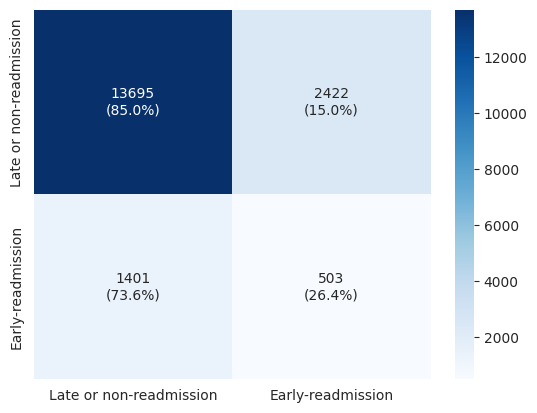

In [24]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [25]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 14, 40, step=2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 16, 100, step=2)
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        RandomForestClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    f1_score = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation F1-scores: {}".format(f1_score))
    print("Average F1-score: {}".format(f1_score.mean()))

    return f1_score.mean()

In [26]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2024-12-29 14:17:21,307] A new study created in Journal with name: Diabetes_130-US


### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [27]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2024-12-29 14:18:01,156] Trial 3 finished with value: 0.5353426896044013 and parameters: {'max_depth': 34, 'min_samples_leaf': 80}. Best is trial 3 with value: 0.5353426896044013.


Cross validation F1-scores: [0.53041507 0.53055619 0.53771994 0.53210517 0.54591708]
Average F1-score: 0.5353426896044013


[I 2024-12-29 14:18:02,619] Trial 8 finished with value: 0.5343016779341699 and parameters: {'max_depth': 34, 'min_samples_leaf': 92}. Best is trial 3 with value: 0.5353426896044013.


Cross validation F1-scores: [0.5273448  0.52947867 0.53613409 0.53470286 0.54384797]
Average F1-score: 0.5343016779341699


[I 2024-12-29 14:18:02,881] Trial 4 finished with value: 0.5358920518050905 and parameters: {'max_depth': 40, 'min_samples_leaf': 98}. Best is trial 4 with value: 0.5358920518050905.


Cross validation F1-scores: [0.5353559  0.53163214 0.53745889 0.53210964 0.54290368]
Average F1-score: 0.5358920518050905


[I 2024-12-29 14:18:04,443] Trial 0 finished with value: 0.5377889945159613 and parameters: {'max_depth': 32, 'min_samples_leaf': 52}. Best is trial 0 with value: 0.5377889945159613.
[I 2024-12-29 14:18:04,460] Trial 1 finished with value: 0.5368452335955783 and parameters: {'max_depth': 40, 'min_samples_leaf': 76}. Best is trial 0 with value: 0.5377889945159613.


Cross validation F1-scores: [0.52804168 0.53505727 0.54102611 0.53982623 0.54499369]
Average F1-score: 0.5377889945159613
Cross validation F1-scores: [0.5310044  0.5340657  0.54019011 0.53427905 0.54468691]
Average F1-score: 0.5368452335955783


[I 2024-12-29 14:18:04,765] Trial 5 finished with value: 0.5359824376347317 and parameters: {'max_depth': 32, 'min_samples_leaf': 82}. Best is trial 0 with value: 0.5377889945159613.


Cross validation F1-scores: [0.53050303 0.53367515 0.53769197 0.53332209 0.54471995]
Average F1-score: 0.5359824376347317


[I 2024-12-29 14:18:05,037] Trial 6 finished with value: 0.5347743125951878 and parameters: {'max_depth': 28, 'min_samples_leaf': 100}. Best is trial 0 with value: 0.5377889945159613.


Cross validation F1-scores: [0.52968464 0.53032724 0.54001605 0.53147626 0.54236737]
Average F1-score: 0.5347743125951878


[I 2024-12-29 14:18:05,566] Trial 10 finished with value: 0.5379120830690719 and parameters: {'max_depth': 40, 'min_samples_leaf': 52}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52812086 0.53559353 0.54102611 0.53982623 0.54499369]
Average F1-score: 0.5379120830690719


[I 2024-12-29 14:18:07,371] Trial 9 finished with value: 0.5345778080107364 and parameters: {'max_depth': 36, 'min_samples_leaf': 32}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52474182 0.53154948 0.54193676 0.53645728 0.53820369]
Average F1-score: 0.5345778080107364


[I 2024-12-29 14:18:08,469] Trial 7 finished with value: 0.5345778080107364 and parameters: {'max_depth': 34, 'min_samples_leaf': 32}. Best is trial 10 with value: 0.5379120830690719.
[I 2024-12-29 14:18:08,498] Trial 11 finished with value: 0.533935079037095 and parameters: {'max_depth': 40, 'min_samples_leaf': 36}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52474182 0.53154948 0.54193676 0.53645728 0.53820369]
Average F1-score: 0.5345778080107364
Cross validation F1-scores: [0.5254506  0.53183198 0.54135127 0.53352209 0.53751945]
Average F1-score: 0.533935079037095


[I 2024-12-29 14:18:08,959] Trial 2 finished with value: 0.5335024346663616 and parameters: {'max_depth': 22, 'min_samples_leaf': 26}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52551821 0.53165842 0.54304412 0.53418949 0.53310193]
Average F1-score: 0.5335024346663616


[I 2024-12-29 14:18:43,425] Trial 12 finished with value: 0.5354362037392069 and parameters: {'max_depth': 18, 'min_samples_leaf': 76}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52781356 0.53011619 0.5352055  0.53660837 0.5474374 ]
Average F1-score: 0.5354362037392069


[I 2024-12-29 14:18:43,948] Trial 13 finished with value: 0.5359714163419959 and parameters: {'max_depth': 30, 'min_samples_leaf': 98}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.5353559  0.53163214 0.53745889 0.53250646 0.54290368]
Average F1-score: 0.5359714163419959


[I 2024-12-29 14:18:44,432] Trial 14 finished with value: 0.5321980426145195 and parameters: {'max_depth': 14, 'min_samples_leaf': 64}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52750595 0.52596921 0.53061238 0.53316574 0.54373693]
Average F1-score: 0.5321980426145195


[I 2024-12-29 14:18:45,713] Trial 16 finished with value: 0.5329678762115206 and parameters: {'max_depth': 18, 'min_samples_leaf': 98}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.5293948  0.52686166 0.53520785 0.53162733 0.54174775]
Average F1-score: 0.5329678762115206


[I 2024-12-29 14:18:46,380] Trial 18 finished with value: 0.5359102762031516 and parameters: {'max_depth': 38, 'min_samples_leaf': 90}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52956313 0.52790704 0.54097374 0.53414576 0.54696171]
Average F1-score: 0.5359102762031516


[I 2024-12-29 14:18:48,026] Trial 15 finished with value: 0.5345673025795705 and parameters: {'max_depth': 34, 'min_samples_leaf': 48}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52667937 0.53043897 0.54094202 0.53746322 0.53731293]
Average F1-score: 0.5345673025795705


[I 2024-12-29 14:18:48,738] Trial 20 finished with value: 0.5353426896044013 and parameters: {'max_depth': 36, 'min_samples_leaf': 80}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.53041507 0.53055619 0.53771994 0.53210517 0.54591708]
Average F1-score: 0.5353426896044013


[I 2024-12-29 14:18:49,376] Trial 17 finished with value: 0.5346877567335884 and parameters: {'max_depth': 34, 'min_samples_leaf': 46}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52474643 0.53524977 0.54092013 0.53210322 0.54041923]
Average F1-score: 0.5346877567335884


[I 2024-12-29 14:18:49,833] Trial 19 finished with value: 0.5336685212553923 and parameters: {'max_depth': 16, 'min_samples_leaf': 20}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.5293697  0.52597362 0.53849766 0.53424949 0.54025213]
Average F1-score: 0.5336685212553923


[I 2024-12-29 14:18:50,067] Trial 21 finished with value: 0.535033699925749 and parameters: {'max_depth': 24, 'min_samples_leaf': 62}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52973911 0.53091842 0.53960166 0.53337137 0.54153795]
Average F1-score: 0.535033699925749


[I 2024-12-29 14:18:51,254] Trial 23 finished with value: 0.537420678024211 and parameters: {'max_depth': 30, 'min_samples_leaf': 68}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.53035522 0.53103556 0.5411977  0.53363105 0.55088386]
Average F1-score: 0.537420678024211


[I 2024-12-29 14:18:52,457] Trial 22 finished with value: 0.5377852863646277 and parameters: {'max_depth': 26, 'min_samples_leaf': 52}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52914279 0.53422999 0.54256572 0.54047888 0.54250904]
Average F1-score: 0.5377852863646277


[I 2024-12-29 14:19:25,455] Trial 24 finished with value: 0.537666709276397 and parameters: {'max_depth': 22, 'min_samples_leaf': 56}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.53103118 0.53314486 0.54428512 0.5352268  0.54464559]
Average F1-score: 0.537666709276397


[I 2024-12-29 14:19:27,540] Trial 27 finished with value: 0.536383240970592 and parameters: {'max_depth': 26, 'min_samples_leaf': 70}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.53099599 0.53303387 0.53931536 0.53376557 0.54480541]
Average F1-score: 0.536383240970592


[I 2024-12-29 14:19:27,795] Trial 25 finished with value: 0.5350957500468565 and parameters: {'max_depth': 38, 'min_samples_leaf': 42}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52622932 0.53193611 0.54005996 0.5331993  0.54405406]
Average F1-score: 0.5350957500468565


[I 2024-12-29 14:19:28,554] Trial 26 finished with value: 0.5352577286794489 and parameters: {'max_depth': 30, 'min_samples_leaf': 42}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.52622932 0.5329466  0.53989227 0.5331993  0.54402115]
Average F1-score: 0.5352577286794489


[I 2024-12-29 14:19:30,096] Trial 29 finished with value: 0.5368573674090015 and parameters: {'max_depth': 40, 'min_samples_leaf': 56}. Best is trial 10 with value: 0.5379120830690719.


Cross validation F1-scores: [0.53200596 0.53368182 0.542074   0.53342701 0.54309805]
Average F1-score: 0.5368573674090015


[I 2024-12-29 14:19:31,106] Trial 30 finished with value: 0.5385367658384365 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 30 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53163973 0.53614671 0.54350334 0.53660587 0.54478819]
Average F1-score: 0.5385367658384365


[I 2024-12-29 14:19:31,442] Trial 32 finished with value: 0.5373760324757917 and parameters: {'max_depth': 36, 'min_samples_leaf': 74}. Best is trial 30 with value: 0.5385367658384365.
[I 2024-12-29 14:19:31,594] Trial 33 finished with value: 0.5373950158763934 and parameters: {'max_depth': 40, 'min_samples_leaf': 86}. Best is trial 30 with value: 0.5385367658384365.


Cross validation F1-scores: [0.53132158 0.53692299 0.53934097 0.53714454 0.54215009]
Average F1-score: 0.5373760324757917
Cross validation F1-scores: [0.52908986 0.53562202 0.54292936 0.53144728 0.54788656]
Average F1-score: 0.5373950158763934


[I 2024-12-29 14:19:32,435] Trial 28 finished with value: 0.5273335564610485 and parameters: {'max_depth': 38, 'min_samples_leaf': 16}. Best is trial 30 with value: 0.5385367658384365.


Cross validation F1-scores: [0.52125402 0.52893277 0.53302443 0.52867041 0.52478616]
Average F1-score: 0.5273335564610485


[I 2024-12-29 14:19:33,145] Trial 34 finished with value: 0.5396042213214296 and parameters: {'max_depth': 30, 'min_samples_leaf': 66}. Best is trial 34 with value: 0.5396042213214296.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.5448397 ]
Average F1-score: 0.5396042213214296


[I 2024-12-29 14:19:34,902] Trial 31 finished with value: 0.5355421858603938 and parameters: {'max_depth': 32, 'min_samples_leaf': 26}. Best is trial 34 with value: 0.5396042213214296.


Cross validation F1-scores: [0.53115244 0.53088844 0.5449642  0.53631758 0.53438826]
Average F1-score: 0.5355421858603938


[I 2024-12-29 14:19:35,750] Trial 35 finished with value: 0.5367683787602038 and parameters: {'max_depth': 26, 'min_samples_leaf': 50}. Best is trial 34 with value: 0.5396042213214296.


Cross validation F1-scores: [0.52824455 0.53166432 0.54070347 0.53691966 0.5463099 ]
Average F1-score: 0.5367683787602038


[I 2024-12-29 14:20:07,857] Trial 36 finished with value: 0.5359593698872188 and parameters: {'max_depth': 28, 'min_samples_leaf': 54}. Best is trial 34 with value: 0.5396042213214296.


Cross validation F1-scores: [0.53047563 0.53053761 0.53932552 0.53504187 0.54441622]
Average F1-score: 0.5359593698872188


[I 2024-12-29 14:20:10,460] Trial 37 finished with value: 0.5368541616641068 and parameters: {'max_depth': 24, 'min_samples_leaf': 52}. Best is trial 34 with value: 0.5396042213214296.


Cross validation F1-scores: [0.52975413 0.53300692 0.53974314 0.53836383 0.5434028 ]
Average F1-score: 0.5368541616641068


[I 2024-12-29 14:20:11,169] Trial 38 finished with value: 0.5345492151753879 and parameters: {'max_depth': 32, 'min_samples_leaf': 40}. Best is trial 34 with value: 0.5396042213214296.


Cross validation F1-scores: [0.52933145 0.52925032 0.54219863 0.53428104 0.53768464]
Average F1-score: 0.5345492151753879


[I 2024-12-29 14:20:11,523] Trial 39 finished with value: 0.5370913572394345 and parameters: {'max_depth': 20, 'min_samples_leaf': 46}. Best is trial 34 with value: 0.5396042213214296.


Cross validation F1-scores: [0.53055193 0.53333229 0.53821362 0.53581871 0.54754023]
Average F1-score: 0.5370913572394345


[I 2024-12-29 14:20:12,773] Trial 43 finished with value: 0.5346969856795984 and parameters: {'max_depth': 20, 'min_samples_leaf': 72}. Best is trial 34 with value: 0.5396042213214296.


Cross validation F1-scores: [0.52926135 0.52802131 0.53783088 0.5340097  0.54436169]
Average F1-score: 0.5346969856795984


[I 2024-12-29 14:20:13,180] Trial 41 finished with value: 0.5385367658384365 and parameters: {'max_depth': 22, 'min_samples_leaf': 60}. Best is trial 34 with value: 0.5396042213214296.


Cross validation F1-scores: [0.53163973 0.53614671 0.54350334 0.53660587 0.54478819]
Average F1-score: 0.5385367658384365


[I 2024-12-29 14:20:14,043] Trial 42 finished with value: 0.5364226665306175 and parameters: {'max_depth': 24, 'min_samples_leaf': 60}. Best is trial 34 with value: 0.5396042213214296.
[I 2024-12-29 14:20:14,097] Trial 40 finished with value: 0.535518968813646 and parameters: {'max_depth': 28, 'min_samples_leaf': 34}. Best is trial 34 with value: 0.5396042213214296.


Cross validation F1-scores: [0.52611677 0.53644822 0.54079827 0.5331481  0.54560197]
Average F1-score: 0.5364226665306175
Cross validation F1-scores: [0.52826325 0.53408775 0.54207806 0.53266643 0.54049936]
Average F1-score: 0.535518968813646


[I 2024-12-29 14:20:14,406] Trial 45 finished with value: 0.5397092179314213 and parameters: {'max_depth': 32, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.54536468]
Average F1-score: 0.5397092179314213


[I 2024-12-29 14:20:16,414] Trial 44 finished with value: 0.53588631403535 and parameters: {'max_depth': 26, 'min_samples_leaf': 38}. Best is trial 45 with value: 0.5397092179314213.
[I 2024-12-29 14:20:16,532] Trial 46 finished with value: 0.5396042213214296 and parameters: {'max_depth': 30, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53174739 0.53191325 0.54008294 0.53529909 0.5403889 ]
Average F1-score: 0.53588631403535
Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.5448397 ]
Average F1-score: 0.5396042213214296


[I 2024-12-29 14:20:16,952] Trial 47 finished with value: 0.5354081737664643 and parameters: {'max_depth': 28, 'min_samples_leaf': 80}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53041507 0.53055619 0.53796682 0.53218571 0.54591708]
Average F1-score: 0.5354081737664643


[I 2024-12-29 14:20:48,766] Trial 48 finished with value: 0.5347243743986733 and parameters: {'max_depth': 32, 'min_samples_leaf': 62}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53015528 0.5281451  0.53789082 0.53508671 0.54234396]
Average F1-score: 0.5347243743986733


[I 2024-12-29 14:20:51,068] Trial 49 finished with value: 0.5368452335955783 and parameters: {'max_depth': 36, 'min_samples_leaf': 76}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.5310044  0.5340657  0.54019011 0.53427905 0.54468691]
Average F1-score: 0.5368452335955783


[I 2024-12-29 14:20:51,388] Trial 50 finished with value: 0.5319753810115821 and parameters: {'max_depth': 14, 'min_samples_leaf': 46}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52782801 0.52515039 0.53023168 0.52991793 0.54674889]
Average F1-score: 0.5319753810115821


[I 2024-12-29 14:20:52,676] Trial 51 finished with value: 0.5350515313340847 and parameters: {'max_depth': 18, 'min_samples_leaf': 58}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52801352 0.52863182 0.54227879 0.53397693 0.54235659]
Average F1-score: 0.5350515313340847


[I 2024-12-29 14:20:54,437] Trial 52 finished with value: 0.5348769916910269 and parameters: {'max_depth': 22, 'min_samples_leaf': 52}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52876109 0.52970343 0.53747682 0.5346589  0.54378471]
Average F1-score: 0.5348769916910269


[I 2024-12-29 14:20:55,037] Trial 56 finished with value: 0.5342915482342406 and parameters: {'max_depth': 16, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.
[I 2024-12-29 14:20:55,077] Trial 55 finished with value: 0.5364679942426053 and parameters: {'max_depth': 24, 'min_samples_leaf': 70}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.5318031  0.52484414 0.53872597 0.53165878 0.54442575]
Average F1-score: 0.5342915482342406
Cross validation F1-scores: [0.53166144 0.53380614 0.5377804  0.53403461 0.54505739]
Average F1-score: 0.5364679942426053


[I 2024-12-29 14:20:55,561] Trial 53 finished with value: 0.5357152645678338 and parameters: {'max_depth': 22, 'min_samples_leaf': 58}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.5257136  0.53636789 0.53974868 0.53418556 0.54256059]
Average F1-score: 0.5357152645678338


[I 2024-12-29 14:20:56,072] Trial 54 finished with value: 0.5357780522445508 and parameters: {'max_depth': 20, 'min_samples_leaf': 62}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52874531 0.53236577 0.53801669 0.53332944 0.54643306]
Average F1-score: 0.5357780522445508


[I 2024-12-29 14:20:57,981] Trial 57 finished with value: 0.5384680790254577 and parameters: {'max_depth': 32, 'min_samples_leaf': 64}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53184403 0.53408957 0.54129151 0.53817072 0.54694457]
Average F1-score: 0.5384680790254577


[I 2024-12-29 14:20:58,566] Trial 59 finished with value: 0.5363796279131959 and parameters: {'max_depth': 30, 'min_samples_leaf': 84}. Best is trial 45 with value: 0.5397092179314213.
[I 2024-12-29 14:20:58,614] Trial 58 finished with value: 0.5396042213214296 and parameters: {'max_depth': 30, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53201922 0.52856386 0.53977911 0.53451153 0.54702442]
Average F1-score: 0.5363796279131959
Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.5448397 ]
Average F1-score: 0.5396042213214296


[I 2024-12-29 14:21:30,091] Trial 60 finished with value: 0.5372953678839607 and parameters: {'max_depth': 28, 'min_samples_leaf': 74}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53132158 0.53692299 0.53893765 0.53714454 0.54215009]
Average F1-score: 0.5372953678839607


[I 2024-12-29 14:21:33,291] Trial 61 finished with value: 0.5397092179314213 and parameters: {'max_depth': 34, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.54536468]
Average F1-score: 0.5397092179314213


[I 2024-12-29 14:21:34,131] Trial 62 finished with value: 0.5375058419036456 and parameters: {'max_depth': 34, 'min_samples_leaf': 60}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.5272566  0.53716148 0.5422892  0.53484584 0.5459761 ]
Average F1-score: 0.5375058419036456


[I 2024-12-29 14:21:35,332] Trial 63 finished with value: 0.5367041092149136 and parameters: {'max_depth': 30, 'min_samples_leaf': 56}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53200596 0.53368182 0.54130771 0.53342701 0.54309805]
Average F1-score: 0.5367041092149136


[I 2024-12-29 14:21:35,778] Trial 64 finished with value: 0.5356472043444995 and parameters: {'max_depth': 38, 'min_samples_leaf': 70}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53073165 0.53196084 0.53867785 0.53360297 0.54326271]
Average F1-score: 0.5356472043444995


[I 2024-12-29 14:21:36,287] Trial 66 finished with value: 0.5364017814671775 and parameters: {'max_depth': 20, 'min_samples_leaf': 76}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52972916 0.53092888 0.54379375 0.53262055 0.54493656]
Average F1-score: 0.5364017814671775


[I 2024-12-29 14:21:36,945] Trial 65 finished with value: 0.5373691430044363 and parameters: {'max_depth': 32, 'min_samples_leaf': 68}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53035522 0.53077789 0.5411977  0.53363105 0.55088386]
Average F1-score: 0.5373691430044363


[I 2024-12-29 14:21:38,654] Trial 67 finished with value: 0.5354140073475656 and parameters: {'max_depth': 22, 'min_samples_leaf': 48}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52723126 0.53138405 0.54250829 0.53581327 0.54013318]
Average F1-score: 0.5354140073475656


[I 2024-12-29 14:21:38,996] Trial 68 finished with value: 0.5376688422512459 and parameters: {'max_depth': 26, 'min_samples_leaf': 60}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52733549 0.53782426 0.54302434 0.53385875 0.54630137]
Average F1-score: 0.5376688422512459


[I 2024-12-29 14:21:40,120] Trial 69 finished with value: 0.5384680790254577 and parameters: {'max_depth': 32, 'min_samples_leaf': 64}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53184403 0.53408957 0.54129151 0.53817072 0.54694457]
Average F1-score: 0.5384680790254577


[I 2024-12-29 14:21:40,527] Trial 71 finished with value: 0.5396042213214296 and parameters: {'max_depth': 30, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.
[I 2024-12-29 14:21:40,598] Trial 70 finished with value: 0.536846635269536 and parameters: {'max_depth': 32, 'min_samples_leaf': 72}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.5448397 ]
Average F1-score: 0.5396042213214296
Cross validation F1-scores: [0.53096009 0.5315279  0.53963064 0.53606595 0.54604859]
Average F1-score: 0.536846635269536


[I 2024-12-29 14:22:11,714] Trial 72 finished with value: 0.5384680790254577 and parameters: {'max_depth': 30, 'min_samples_leaf': 64}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53184403 0.53408957 0.54129151 0.53817072 0.54694457]
Average F1-score: 0.5384680790254577


[I 2024-12-29 14:22:15,554] Trial 74 finished with value: 0.5397092179314213 and parameters: {'max_depth': 34, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.
[I 2024-12-29 14:22:15,641] Trial 73 finished with value: 0.5373691430044363 and parameters: {'max_depth': 34, 'min_samples_leaf': 68}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.54536468]
Average F1-score: 0.5397092179314213
Cross validation F1-scores: [0.53035522 0.53077789 0.5411977  0.53363105 0.55088386]
Average F1-score: 0.5373691430044363


[I 2024-12-29 14:22:15,980] Trial 75 finished with value: 0.5353106727079984 and parameters: {'max_depth': 28, 'min_samples_leaf': 78}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53024641 0.52981882 0.53881804 0.5315784  0.5460917 ]
Average F1-score: 0.5353106727079984


[I 2024-12-29 14:22:17,982] Trial 76 finished with value: 0.5358294258063196 and parameters: {'max_depth': 30, 'min_samples_leaf': 54}. Best is trial 45 with value: 0.5397092179314213.
[I 2024-12-29 14:22:18,123] Trial 77 finished with value: 0.5368799193582362 and parameters: {'max_depth': 34, 'min_samples_leaf': 72}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53111947 0.52976898 0.53907537 0.53482404 0.54435928]
Average F1-score: 0.5358294258063196
Cross validation F1-scores: [0.53096009 0.5315279  0.53979706 0.53606595 0.54604859]
Average F1-score: 0.5368799193582362


[I 2024-12-29 14:22:19,104] Trial 78 finished with value: 0.537655826794805 and parameters: {'max_depth': 28, 'min_samples_leaf': 60}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52776795 0.53707878 0.54244635 0.53500996 0.5459761 ]
Average F1-score: 0.537655826794805


[I 2024-12-29 14:22:20,308] Trial 79 finished with value: 0.5373691430044363 and parameters: {'max_depth': 36, 'min_samples_leaf': 68}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53035522 0.53077789 0.5411977  0.53363105 0.55088386]
Average F1-score: 0.5373691430044363


[I 2024-12-29 14:22:20,910] Trial 80 finished with value: 0.5347243743986733 and parameters: {'max_depth': 30, 'min_samples_leaf': 62}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53015528 0.5281451  0.53789082 0.53508671 0.54234396]
Average F1-score: 0.5347243743986733


[I 2024-12-29 14:22:22,743] Trial 81 finished with value: 0.5366350936310057 and parameters: {'max_depth': 32, 'min_samples_leaf': 56}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53200596 0.53368182 0.54096263 0.53342701 0.54309805]
Average F1-score: 0.5366350936310057


[I 2024-12-29 14:22:23,089] Trial 83 finished with value: 0.5396042213214296 and parameters: {'max_depth': 30, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.5448397 ]
Average F1-score: 0.5396042213214296


[I 2024-12-29 14:22:23,481] Trial 82 finished with value: 0.5396042213214296 and parameters: {'max_depth': 30, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.5448397 ]
Average F1-score: 0.5396042213214296


[I 2024-12-29 14:22:54,321] Trial 84 finished with value: 0.5356993911326727 and parameters: {'max_depth': 28, 'min_samples_leaf': 70}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53081179 0.53196084 0.53842969 0.53360297 0.54369167]
Average F1-score: 0.5356993911326727


[I 2024-12-29 14:22:57,678] Trial 86 finished with value: 0.5373760324757917 and parameters: {'max_depth': 36, 'min_samples_leaf': 74}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53132158 0.53692299 0.53934097 0.53714454 0.54215009]
Average F1-score: 0.5373760324757917


[I 2024-12-29 14:22:58,379] Trial 87 finished with value: 0.5347243743986733 and parameters: {'max_depth': 34, 'min_samples_leaf': 62}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53015528 0.5281451  0.53789082 0.53508671 0.54234396]
Average F1-score: 0.5347243743986733


[I 2024-12-29 14:22:59,181] Trial 85 finished with value: 0.5397092179314213 and parameters: {'max_depth': 34, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.54536468]
Average F1-score: 0.5397092179314213


[I 2024-12-29 14:22:59,566] Trial 88 finished with value: 0.5354117192027312 and parameters: {'max_depth': 32, 'min_samples_leaf': 78}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53024641 0.52981882 0.53872122 0.5315784  0.54669375]
Average F1-score: 0.5354117192027312


[I 2024-12-29 14:22:59,963] Trial 89 finished with value: 0.5384680790254577 and parameters: {'max_depth': 34, 'min_samples_leaf': 64}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53184403 0.53408957 0.54129151 0.53817072 0.54694457]
Average F1-score: 0.5384680790254577


[I 2024-12-29 14:23:00,610] Trial 90 finished with value: 0.5373691430044363 and parameters: {'max_depth': 32, 'min_samples_leaf': 68}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53035522 0.53077789 0.5411977  0.53363105 0.55088386]
Average F1-score: 0.5373691430044363


[I 2024-12-29 14:23:01,572] Trial 91 finished with value: 0.5367263877569275 and parameters: {'max_depth': 28, 'min_samples_leaf': 72}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53096009 0.5315279  0.54020481 0.53606595 0.54487318]
Average F1-score: 0.5367263877569275


[I 2024-12-29 14:23:02,174] Trial 92 finished with value: 0.5361775691774302 and parameters: {'max_depth': 34, 'min_samples_leaf': 58}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.52642116 0.5341707  0.53982991 0.53392997 0.54653612]
Average F1-score: 0.5361775691774302


[I 2024-12-29 14:23:03,054] Trial 93 finished with value: 0.5392705752726263 and parameters: {'max_depth': 24, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53363329 0.53538623 0.54446445 0.53871417 0.54415474]
Average F1-score: 0.5392705752726263


[I 2024-12-29 14:23:03,500] Trial 94 finished with value: 0.5396042213214296 and parameters: {'max_depth': 30, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.5448397 ]
Average F1-score: 0.5396042213214296


[I 2024-12-29 14:23:03,875] Trial 95 finished with value: 0.5356472043444995 and parameters: {'max_depth': 30, 'min_samples_leaf': 70}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53073165 0.53196084 0.53867785 0.53360297 0.54326271]
Average F1-score: 0.5356472043444995


[I 2024-12-29 14:23:19,551] Trial 96 finished with value: 0.5396042213214296 and parameters: {'max_depth': 30, 'min_samples_leaf': 66}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53285244 0.53552338 0.54532261 0.53948298 0.5448397 ]
Average F1-score: 0.5396042213214296


[I 2024-12-29 14:23:21,579] Trial 97 finished with value: 0.5373760324757917 and parameters: {'max_depth': 32, 'min_samples_leaf': 74}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53132158 0.53692299 0.53934097 0.53714454 0.54215009]
Average F1-score: 0.5373760324757917


[I 2024-12-29 14:23:22,060] Trial 98 finished with value: 0.5384680790254577 and parameters: {'max_depth': 30, 'min_samples_leaf': 64}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53184403 0.53408957 0.54129151 0.53817072 0.54694457]
Average F1-score: 0.5384680790254577


[I 2024-12-29 14:23:22,298] Trial 99 finished with value: 0.5354117192027312 and parameters: {'max_depth': 36, 'min_samples_leaf': 78}. Best is trial 45 with value: 0.5397092179314213.


Cross validation F1-scores: [0.53024641 0.52981882 0.53872122 0.5315784  0.54669375]
Average F1-score: 0.5354117192027312


In [28]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 45
Best Parameters: {'max_depth': 32, 'min_samples_leaf': 66}
Best Value: 0.5397092179314213


### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [29]:
optuna.visualization.plot_optimization_history(study)

In [30]:
optuna.visualization.plot_slice(study)

In [31]:
optuna.visualization.plot_param_importances(study)

In [32]:
optuna.visualization.plot_parallel_coordinate(study)

In [33]:
optuna.visualization.plot_contour(study)

In [34]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [35]:
# Fit best model on the training set
best_params = study.best_params

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(random_state=38,
                            tomek=TomekLinks(sampling_strategy='majority'))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=32, min_samples_leaf=66,
                                        random_state=38))])

In [36]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [37]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

Train accuracy:  0.8000856164383562
Test accuracy:  0.7793130236945786


In [38]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      0.84      0.87     16117
      Early-readmission       0.17      0.27      0.21      1904

               accuracy                           0.78     18021
              macro avg       0.54      0.56      0.54     18021
           weighted avg       0.83      0.78      0.80     18021



In [39]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

<Axes: >

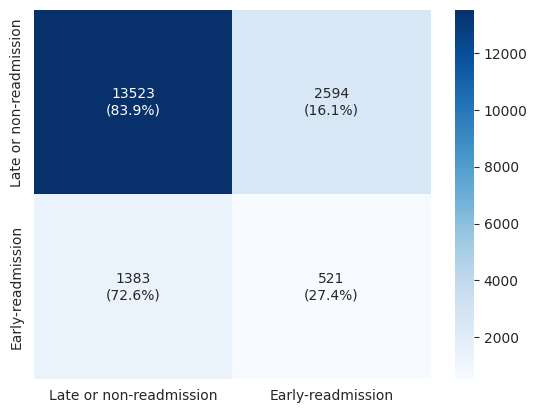

In [40]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

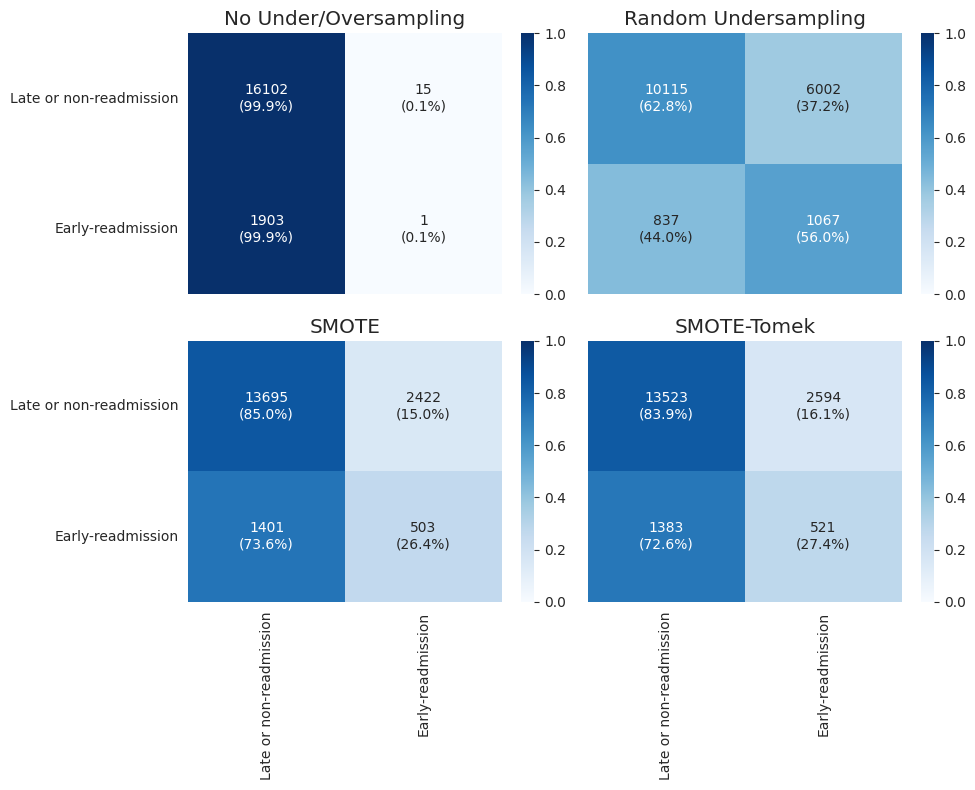

In [69]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [70]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

,Recall,Precision,F1-score,ROC-AUC,Accuracy
No Under/Oversampling,0.499797,0.478404,0.472416,0.499797,0.893569
Random Undersampling,0.593999,0.537258,0.492587,0.593999,0.620498
SMOTE,0.556952,0.539580,0.542922,0.556952,0.787859
SMOTE-Tomek,0.556343,0.537237,0.539708,0.556343,0.779313
